In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
## 0) Dépendances
import os, sys, math, time, json, random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

try:
    import cv2
except Exception:
    # Sur Kaggle, cette installation est généralement disponible; sinon on installe.
    !pip -q install opencv-python-headless
    import cv2

print('Versions -> python', sys.version.split()[0])
print('torch', torch.__version__)
device = 0 if torch.cuda.is_available() else 'cpu'
print('Device =', device)

Versions -> python 3.11.13
torch 2.6.0+cu124
Device = 0


In [3]:
## 1) Configuration (selon votre message)
IN_ROOT = Path('/kaggle/input/nih-nlm-thinbloodsmearspf')
POLY    = IN_ROOT / 'Polygon Set'   # patients (GT/ & Img/)
OUT     = Path('/kaggle/working/nih_yolo')

# Dossiers sortie tuiles
OUT_IMG = OUT / 'images'
OUT_LBL = OUT / 'labels'
for s in ['train','val','test']:
    (OUT_IMG/s).mkdir(parents=True, exist_ok=True)
    (OUT_LBL/s).mkdir(parents=True, exist_ok=True)

# Paramètres de tiling
TILE = 640
STRIDE = 640  # pas de redimensionnement; recouvrement uniquement aux bords si non divisible
EDGE_ALIGN = True  # ancre la dernière tuile au bord (garantit la couverture)
TILE_SAVE_FORMAT = 'PNG'  # 'PNG' (sans perte) ou 'JPEG' (si espace disque serré)
JPEG_QUALITY = 95         # utilisé si TILE_SAVE_FORMAT == 'JPEG'

# Filtrage des boxes partiellement visibles dans une tuile
MIN_VIS_AREA_PX = 120      # surface min. d'intersection en pixels
MIN_VIS_FRAC = 0.8        # fraction min. (aire_intersection / aire_boite_orig)

assert POLY.exists(), f'Introuvable: {POLY}. Vérifiez le chemin Kaggle.'
print('POLY =', POLY)
print('OUT  =', OUT)


POLY = /kaggle/input/nih-nlm-thinbloodsmearspf/Polygon Set
OUT  = /kaggle/working/nih_yolo


In [4]:
## 2) Utilitaires parsing, split & géométrie
def find_subdir_case_insensitive(base: Path, name: str) -> Path:
    for child in base.iterdir():
        if child.is_dir() and child.name.lower() == name.lower():
            return child
    return base / name

def parse_first_line(line: str) -> Tuple[int, int, int]:
    toks = [t for t in re.split(r'[\s,]+', line.strip()) if t!='']
    if len(toks) < 3:
        raise ValueError('Ligne 1 invalide')
    n = int(float(toks[0])); W = int(float(toks[1])); H = int(float(toks[2]))
    return n, W, H

CLS_NAMES = ['RBC_uninfected', 'RBC_parasitized', 'WBC']
CLS_MAP = {
    'Uninfected': 0,
    'Parasitized': 1,
    'White_Blood_Cell': 2,
}

def map_class(label: str):
    if label in CLS_MAP:
        return CLS_MAP[label]
    l = label.strip().lower()
    if 'white' in l and 'blood' in l: return 2
    if 'uninfect' in l: return 0
    if 'paras' in l: return 1
    return None

def parse_gt_file(gt_path: Path):
    txt = gt_path.read_text(encoding='utf-8', errors='ignore')
    lines = [ln for ln in txt.strip().splitlines() if ln.strip()!='']
    if not lines:
        return [], None
    try:
        _, W, H = parse_first_line(lines[0])
    except Exception:
        W = H = None
    dets = []
    for ln in lines[1:]:
        parts = [p.strip() for p in ln.split(',') if p.strip()!='']
        if len(parts) < 6:
            continue
        cell_type = parts[1]
        shape = parts[3]
        if shape.lower() != 'polygon':
            continue
        try:
            npts = int(float(parts[4]))
        except Exception:
            continue
        coords = parts[5:5+2*npts]
        if len(coords) < 2*npts:
            continue
        try:
            xs = [float(coords[i]) for i in range(0, len(coords), 2)]
            ys = [float(coords[i+1]) for i in range(0, len(coords), 2)]
        except Exception:
            continue
        if not xs or not ys:
            continue
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)
        cls = map_class(cell_type)
        if cls is None:
            continue
        dets.append((cls, x_min, y_min, x_max, y_max))
    return dets, (W, H)

def tile_starts(L: int, tile: int, stride: int, edge_align=True):
    starts = list(range(0, max(1, L - tile + 1), stride))
    if edge_align:
        last = max(0, L - tile)
        if last not in starts:
            starts.append(last)
    return sorted(set(starts))

def intersect_box_with_tile(box, tx, ty, t):
    cls, x0, y0, x1, y1 = box
    xi0 = max(x0, tx); yi0 = max(y0, ty)
    xi1 = min(x1, tx + t); yi1 = min(y1, ty + t)
    if xi1 <= xi0 or yi1 <= yi0:
        return None
    return (cls, xi0, yi0, xi1, yi1)

def to_yolo_from_tile(box_tile, tx, ty, t):
    cls, x0, y0, x1, y1 = box_tile
    # coordonnées relatives à la tuile
    rx0 = x0 - tx; ry0 = y0 - ty; rx1 = x1 - tx; ry1 = y1 - ty
    w = max(0.0, rx1 - rx0); h = max(0.0, ry1 - ry0)
    if w <= 0 or h <= 0: return None
    cx = (rx0 + rx1) / 2.0; cy = (ry0 + ry1) / 2.0
    return (cls, cx / t, cy / t, w / t, h / t)


In [5]:
## 3) Split patients (70/15/15)
patients = sorted([p for p in POLY.iterdir() if p.is_dir()])
print('Nombre de dossiers patient:', len(patients))
random.seed(0)
random.shuffle(patients)
n = len(patients)
n_train = int(0.70*n)
n_val   = int(0.15*n)
train_pat = set(patients[:n_train])
val_pat   = set(patients[n_train:n_train+n_val])
test_pat  = set(patients[n_train+n_val:])
print('Split => train:', len(train_pat), 'val:', len(val_pat), 'test:', len(test_pat))

def split_of(patient_dir: Path) -> str:
    if patient_dir in train_pat: return 'train'
    if patient_dir in val_pat: return 'val'
    return 'test'


Nombre de dossiers patient: 33
Split => train: 23 val: 4 test: 6


In [6]:
## 4) Tiling + génération labels (sans redimensionnement)
tile_total = 0
ann_total = 0
cls_counts = {0:0, 1:0, 2:0}
problem_files = []

for patient in tqdm(patients, desc='Patients'):
    split = split_of(patient)
    p_img = find_subdir_case_insensitive(patient, 'Img')
    p_gt  = find_subdir_case_insensitive(patient, 'GT')
    if not p_img.exists() or not p_gt.exists():
        print('[AVERTISSEMENT] Dossiers Img/GT manquants pour', patient.name)
        continue
    for img_path in sorted(p_img.glob('*.jpg')):
        gt_path = p_gt / (img_path.stem + '.txt')

        # Lire annotations et taille
        dets_abs = []
        W = H = None
        if gt_path.exists():
            try:
                dets_abs, wh = parse_gt_file(gt_path)
                if wh and wh[0] and wh[1]:
                    W, H = wh
            except Exception as e:
                problem_files.append((gt_path, str(e)))
        try:
            with Image.open(img_path) as im:
                if W is None or H is None:
                    W, H = im.size
                xs = tile_starts(W, TILE, STRIDE, EDGE_ALIGN)
                ys = tile_starts(H, TILE, STRIDE, EDGE_ALIGN)
                for ty in ys:
                    for tx in xs:
                        # Compose nom tuile
                        tile_name = f"{img_path.stem}_x{tx}_y{ty}"
                        out_img = OUT_IMG / split / f"{tile_name}.{'png' if TILE_SAVE_FORMAT.upper()=='PNG' else 'jpg'}"
                        out_lbl = OUT_LBL / split / f"{tile_name}.txt"

                        # Recadrage
                        crop = im.crop((tx, ty, tx+TILE, ty+TILE))
                        # Sauvegarde lossless par défaut
                        if TILE_SAVE_FORMAT.upper() == 'PNG':
                            crop.save(out_img, format='PNG')
                        else:
                            crop.save(out_img, format='JPEG', quality=JPEG_QUALITY, subsampling=0)

                        # Labels intersectés
                        tile_lines = []
                        for box in dets_abs:
                            # aire originale
                            _, x0, y0, x1, y1 = box
                            orig_area = max(0.0, x1-x0) * max(0.0, y1-y0)
                            if orig_area <= 0:
                                continue
                            inter = intersect_box_with_tile(box, tx, ty, TILE)
                            if inter is None:
                                continue
                            _, ix0, iy0, ix1, iy1 = inter
                            ia = max(0.0, ix1-ix0) * max(0.0, iy1-iy0)
                            if ia < MIN_VIS_AREA_PX or (ia / orig_area) < MIN_VIS_FRAC:
                                continue
                            yolo = to_yolo_from_tile(inter, tx, ty, TILE)
                            if yolo is not None:
                                cls, cx, cy, w, h = yolo
                                tile_lines.append(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")
                                cls_counts[cls] += 1
                                ann_total += 1

                        out_lbl.write_text('\n'.join(tile_lines))
                        tile_total += 1
        except Exception as e:
            problem_files.append((img_path, f'Erreur ouverture/traitement image: {e}'))

print('Tuiles créées :', tile_total)
print('Annotations (boîtes) :', ann_total)
print('Par classe :', {k: int(v) for k, v in cls_counts.items()})
if problem_files:
    print('Fichiers problématiques (exemples):', problem_files[:5])


Patients: 100%|██████████| 33/33 [10:07<00:00, 18.42s/it]

Tuiles créées : 7425
Annotations (boîtes) : 28671
Par classe : {0: 27716, 1: 921, 2: 34}


In [7]:
## 5) data.yaml pour Ultralytics (tuiles)
data = {
    'path': str(OUT.resolve()),
    'train': 'images/train',
    'val':   'images/val',
    'test':  'images/test',
    'names': {0: 'RBC_uninfected', 1: 'RBC_parasitized', 2: 'WBC'},
}
yaml_path = OUT / 'data.yaml'
with open(yaml_path, 'w') as f:
    import yaml
    yaml.safe_dump(data, f, sort_keys=False)
print('Écrit :', yaml_path)
import yaml as _yaml
print(_yaml.safe_dump(data, sort_keys=False))


Écrit : /kaggle/working/nih_yolo/data.yaml
path: /kaggle/working/nih_yolo
train: images/train
val: images/val
test: images/test
names:
  0: RBC_uninfected
  1: RBC_parasitized
  2: WBC



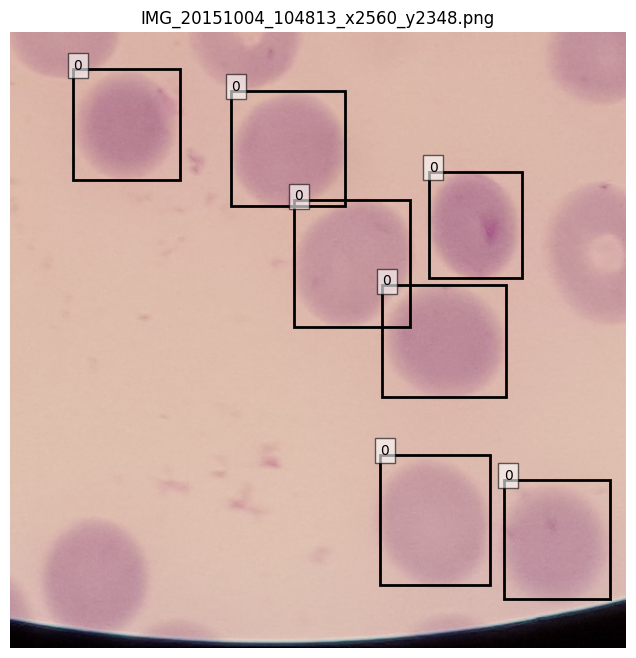

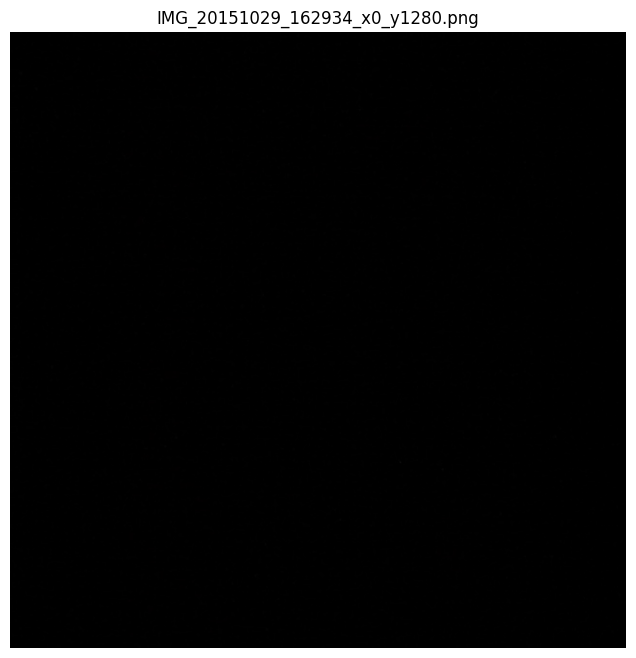

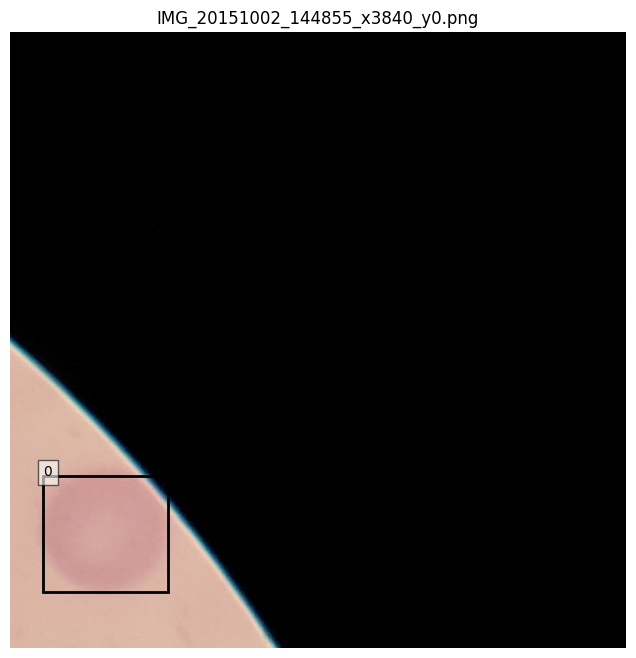

In [8]:
## 6) Sanity-check sur quelques tuiles
import matplotlib.pyplot as plt
from random import sample
import numpy as np
from PIL import Image

def show_tile_samples(split='train', k=3):
    imgs = sorted((OUT_IMG/split).glob('*.png')) + sorted((OUT_IMG/split).glob('*.jpg'))
    if not imgs:
        print('Aucune tuile trouvée dans', OUT_IMG/split)
        return
    for p in sample(imgs, min(k, len(imgs))):
        lbl = OUT_LBL / split / (p.stem + '.txt')
        im = np.array(Image.open(p).convert('RGB'))
        H, W = im.shape[:2]
        plt.figure(figsize=(8,8))
        plt.imshow(im)
        if lbl.exists():
            for line in lbl.read_text().splitlines():
                if not line.strip(): continue
                cls, cx, cy, w, h = map(float, line.split())
                cx *= W; cy *= H; w *= W; h *= H
                x0 = cx - w/2; y0 = cy - h/2
                rect = plt.Rectangle((x0, y0), w, h, fill=False, linewidth=2)
                plt.gca().add_patch(rect)
                plt.text(x0, y0, f'{int(cls)}', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
        plt.axis('off'); plt.title(p.name)
        plt.show()

show_tile_samples('train', k=3)


In [9]:
## 1) Configuration
OUT = Path('/kaggle/working/nih_yolo')  # dataset root
assert OUT.exists(), "Le dossier /kaggle/working/nih_yolo est introuvable. Exécutez d'abord le notebook de préparation (tiling)."

IMG_SIZE = 640
NUM_CLASSES = 3  # RBC_uninfected, RBC_parasitized, WBC
CLASS_NAMES = {0:'RBC_uninfected', 1:'RBC_parasitized', 2:'WBC'}

# Entraînement
EPOCHS = 50
BATCH_SIZE = 8
LR = 5e-4
WEIGHTS = {'box': 5.0, 'obj': 1.0, 'cls': 1.0}
VAL_EVERY = 1
SEED = 0
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# CLAHE (comme le pipeline précédent)
USE_CLAHE = True
CLAHE_CLIP = 2.0
CLAHE_TILE_GRID = (8, 8)
CLAHE_SPACE = 'LAB'  # 'LAB' ou 'HSV'

# Oversampling des classes minoritaires
BALANCE = True
OVERSAMPLE_ALPHA = 1.0    # poids ~ (max_count / count_c)^alpha
WEIGHT_EMPTY = 0.1        # poids pour tuiles sans objets

SAVE_DIR = OUT / 'yolokan11_runs'
SAVE_DIR.mkdir(parents=True, exist_ok=True)
print('SAVE_DIR =', SAVE_DIR)

SAVE_DIR = /kaggle/working/nih_yolo/yolokan11_runs


## 2) Architecture YOLOKAN11 (KAN)

In [10]:
import math
import torch
import torch.nn as nn

def autopad(k, p=None, d=1):
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]
    return p

class ChebyKANConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, degree=3, 
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.degree = degree
        self.kernel_size = kernel_size
        
        self.conv = nn.Conv2d(
            in_channels * (self.degree + 1), out_channels, 
            kernel_size, stride, padding, dilation, groups, bias
        )
        self._initialize_weights()
    
    def _initialize_weights(self):
        fan_in = self.in_channels * (self.degree + 1) * self.kernel_size * self.kernel_size
        std = math.sqrt(2.0 / fan_in)
        nn.init.normal_(self.conv.weight, mean=0.0, std=std)
        if self.conv.bias is not None:
            nn.init.zeros_(self.conv.bias)
    
    def chebyshev_polynomials(self, x, degree):
        x_norm = torch.tanh(x)
        T0 = torch.ones_like(x_norm)
        if degree == 0: 
            return [T0]
        T1 = x_norm
        polynomials = [T0, T1]
        for i in range(2, degree + 1):
            T_next = 2 * x_norm * T1 - T0
            polynomials.append(T_next)
            T0, T1 = T1, T_next
        return polynomials
    
    def forward(self, x):
        cheby_basis = self.chebyshev_polynomials(x, self.degree)
        x_expanded = torch.cat(cheby_basis, dim=1)
        return self.conv(x_expanded)

class KANConv(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, degree=3, act=True):
        super().__init__()
        self.conv = ChebyKANConv2d(c1, c2, k, degree, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class KANBottleneck(nn.Module):
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5, degree=3):
        super().__init__()
        c_ = int(c2 * e)
        self.cv1 = KANConv(c1, c_, 1, 1, degree=degree)
        self.cv2 = KANConv(c_, c2, 3, 1, g=g, degree=degree)
        self.add = shortcut and c1 == c2
    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class KANC2f(nn.Module):
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5, degree=3):
        super().__init__()
        self.c = int(c2 * e)
        self.cv1 = KANConv(c1, 2 * self.c, 1, 1, degree=degree)
        self.cv2 = KANConv((2 + n) * self.c, c2, 1, degree=degree)
        self.m = nn.ModuleList(KANBottleneck(self.c, self.c, shortcut, g, e=1.0, degree=degree) for _ in range(n))
    def forward(self, x):
        y = list(self.cv1(x).chunk(2, 1))
        y.extend(m(y[-1]) for m in self.m)
        return self.cv2(torch.cat(y, 1))

class KANSPPF(nn.Module):
    def __init__(self, c1, c2, k=5, degree=3):
        super().__init__()
        c_ = c1 // 2
        self.cv1 = KANConv(c1, c_, 1, 1, degree=degree)
        self.cv2 = KANConv(c_ * 4, c2, 1, 1, degree=degree)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
    def forward(self, x):
        x = self.cv1(x)
        y1 = self.m(x); y2 = self.m(y1); y3 = self.m(y2)
        return self.cv2(torch.cat([x, y1, y2, y3], 1))

class SimpleKANDetectionHead(nn.Module):
    def __init__(self, nc=3, ch=(), degree=3):
        super().__init__()
        self.nc = nc; self.nl = len(ch)
        self.reg_preds = nn.ModuleList(); self.obj_preds = nn.ModuleList(); self.cls_preds = nn.ModuleList()
        for c in ch:
            self.reg_preds.append(nn.Conv2d(c, 4, 1))
            self.obj_preds.append(nn.Conv2d(c, 1, 1))
            self.cls_preds.append(nn.Conv2d(c, self.nc, 1))
        self._initialize_biases()
    def _initialize_biases(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None: nn.init.zeros_(m.bias)
        prior_prob = 0.01
        bias_value = -math.log((1 - prior_prob) / prior_prob)
        for obj_pred in self.obj_preds: nn.init.constant_(obj_pred.bias, bias_value)
        for cls_pred in self.cls_preds: nn.init.constant_(cls_pred.bias, bias_value)
    def forward(self, x):
        outputs = []
        for i in range(self.nl):
            reg_pred = self.reg_preds[i](x[i])
            obj_pred = self.obj_preds[i](x[i])
            cls_pred = self.cls_preds[i](x[i])
            outputs.append(torch.cat([reg_pred, obj_pred, cls_pred], 1))
        return outputs

class YOLOKANv8(nn.Module):
    def __init__(self, nc=3, degree=3, width_multiple=0.5, depth_multiple=0.33):
        super().__init__()
        self.num_classes = nc
        def make_divisible(x, divisor=8): return math.ceil(x / divisor) * divisor
        channels = [make_divisible(c * width_multiple) for c in [32, 64, 128, 256, 512]]
        depth = lambda n: max(round(n * depth_multiple), 1)
        self.stem = KANConv(3, channels[0], k=3, s=2, degree=degree)
        self.stage1 = nn.Sequential(KANConv(channels[0], channels[1], k=3, s=2, degree=degree), KANC2f(channels[1], channels[1], n=depth(3), degree=degree))
        self.stage2 = nn.Sequential(KANConv(channels[1], channels[2], k=3, s=2, degree=degree), KANC2f(channels[2], channels[2], n=depth(6), degree=degree))
        self.stage3 = nn.Sequential(KANConv(channels[2], channels[3], k=3, s=2, degree=degree), KANC2f(channels[3], channels[3], n=depth(6), degree=degree))
        self.stage4 = nn.Sequential(KANConv(channels[3], channels[4], k=3, s=2, degree=degree), KANC2f(channels[4], channels[4], n=depth(3), degree=degree), KANSPPF(channels[4], channels[4], degree=degree))
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.neck1 = KANC2f(channels[4] + channels[3], channels[3], n=depth(3), shortcut=False, degree=degree)
        self.neck2 = KANC2f(channels[3] + channels[2], channels[2], n=depth(3), shortcut=False, degree=degree)
        self.downsample1 = KANConv(channels[2], channels[2], k=3, s=2, degree=degree)
        self.neck3 = KANC2f(channels[2] + channels[3], channels[3], n=depth(3), shortcut=False, degree=degree)
        self.downsample2 = KANConv(channels[3], channels[3], k=3, s=2, degree=degree)
        self.neck4 = KANC2f(channels[3] + channels[4], channels[4], n=depth(3), shortcut=False, degree=degree)
        self.head = SimpleKANDetectionHead(nc=nc, ch=[channels[2], channels[3], channels[4]], degree=degree)
        self.stride = torch.tensor([8., 16., 32.])
    def forward(self, x):
        c1 = self.stem(x)
        c2 = self.stage1(c1)
        c3 = self.stage2(c2)
        c4 = self.stage3(c3)
        c5 = self.stage4(c4)
        p5_up = self.upsample(c5)
        p4 = self.neck1(torch.cat([p5_up, c4], 1))
        p4_up = self.upsample(p4)
        p3 = self.neck2(torch.cat([p4_up, c3], 1))
        p3_down = self.downsample1(p3)
        p4_out = self.neck3(torch.cat([p3_down, p4], 1))
        p4_down = self.downsample2(p4_out)
        p5_out = self.neck4(torch.cat([p4_down, c5], 1))
        return self.head([p3, p4_out, p5_out])

class YOLOKAN11(YOLOKANv8):
    """
    Wrapper 'YOLOKAN-11' au-dessus de YOLOKANv8 avec:
      - presets de scaling (n/s/m/l/x),
      - strides auto-calculés à l'init,
      - init des biais (obj/cls) et fusion BN optionnelle.
    """
    PRESETS = {
        # valeurs proches des YOLO *n/s/m/l/x*
        "n": {"width": 0.25, "depth": 0.33, "degree": 3},
        "s": {"width": 0.50, "depth": 0.33, "degree": 3},
        "m": {"width": 0.75, "depth": 0.67, "degree": 3},
        "l": {"width": 1.00, "depth": 1.00, "degree": 3},
        "x": {"width": 1.25, "depth": 1.00, "degree": 3},
    }

    def __init__(self,
                 nc=3,
                 variant: str = None,              # "n"|"s"|"m"|"l"|"x" ou None si tu passes width/depth à la main
                 degree: int = None,
                 width_multiple: float = None,
                 depth_multiple: float = None,
                 init_imgsz: int = 640):
        # Applique un preset si demandé
        if variant is not None:
            assert variant in self.PRESETS, f"Preset inconnu: {variant}"
            p = self.PRESETS[variant]
            if degree is None:         degree = p["degree"]
            if width_multiple is None: width_multiple = p["width"]
            if depth_multiple is None: depth_multiple = p["depth"]

        # Valeurs par défaut si rien n'est fourni (mêmes que dans le notebook)
        if degree is None:         degree = 3
        if width_multiple is None: width_multiple = 0.5
        if depth_multiple is None: depth_multiple = 0.33

        super().__init__(nc=nc,
                         degree=degree,
                         width_multiple=width_multiple,
                         depth_multiple=depth_multiple)

        # Init des biais obj/cls (prior faible) et strides auto
        self._init_biases(prior=0.01)
        self._init_strides(imgsz=init_imgsz)

    def _init_biases(self, prior=0.01):
        bias_value = -math.log((1 - prior) / prior)
        for m in self.head.obj_preds:
            if m.bias is not None:
                nn.init.constant_(m.bias, bias_value)
        for m in self.head.cls_preds:
            if m.bias is not None:
                nn.init.constant_(m.bias, bias_value)

    @torch.no_grad()
    def _init_strides(self, imgsz=640):
        """Calcule les strides en fonction des tailles de cartes P3/P4/P5."""
        self.eval()
        dev = next(self.parameters()).device
        x = torch.zeros(1, 3, imgsz, imgsz, device=dev)
        outs = super().forward(x)                     # liste [P3,P4,P5] => [B,C,H,W]
        strides = [imgsz / o.shape[-1] for o in outs] # imgsz / W
        self.stride = torch.tensor(strides, device=dev)
        self.train()

    def fuse(self):
        """
        Fait une fusion BN->Conv dans les blocs KANConv (conv.conv + bn -> conv.bias, BN=Identity).
        Utile pour l'inférence.
        """
        for m in self.modules():
            if isinstance(m, KANConv) and isinstance(m.bn, nn.BatchNorm2d):
                conv = m.conv.conv                     # nn.Conv2d interne de ChebyKANConv2d
                bn = m.bn
                # récup. params
                w = conv.weight
                b = conv.bias if conv.bias is not None else torch.zeros(w.size(0), device=w.device)
                gamma, beta = bn.weight, bn.bias
                mean, var, eps = bn.running_mean, bn.running_var, bn.eps
                std = torch.sqrt(var + eps)
                # fusion
                w *= (gamma / std).reshape(-1, 1, 1, 1)
                b = (b - mean) / std * gamma + beta
                conv.bias = nn.Parameter(b)
                m.bn = nn.Identity()
        return self  # chaining

    @classmethod
    def from_preset(cls, preset="s", nc=3, **kwargs):
        """Construction rapide: YOLOKAN11.from_preset('s', nc=3)"""
        return cls(nc=nc, variant=preset, **kwargs)


## 3) Paramètres

In [11]:
def count_params(m): return sum(p.numel() for p in m.parameters())

DEGREE = 3
WIDTH_MULT = 0.5
DEPTH_MULT = 0.33

model = YOLOKAN11(nc=NUM_CLASSES, degree=DEGREE, width_multiple=WIDTH_MULT, depth_multiple=DEPTH_MULT).to(device)
total_params_kan = count_params(model)

kan_conv_params = conv_baseline_params = bn_params = head_params = 0
layers = []
for name, m in model.named_modules():
    if isinstance(m, ChebyKANConv2d):
        w = m.conv.weight
        kparams = w.numel() + (m.conv.bias.numel() if m.conv.bias is not None else 0)
        bparams = kparams // (DEGREE + 1)
        kan_conv_params += kparams; conv_baseline_params += bparams
        layers.append([name, list(w.shape), kparams, bparams, round(kparams/max(1,bparams),3)])
    elif isinstance(m, nn.BatchNorm2d):
        bn_params += (m.weight.numel() + m.bias.numel())

for n,p in model.named_parameters():
    if 'reg_preds' in n or 'obj_preds' in n or 'cls_preds' in n:
        head_params += p.numel()

total_baseline = conv_baseline_params + bn_params + head_params

print('Params YOLOKAN :', total_params_kan)
print('Params baseline≈Conv :', total_baseline)
print('  - KAN conv params :', kan_conv_params)
print('  - baseline conv params :', conv_baseline_params)
print('  - BN params :', bn_params)
print('  - Head params :', head_params)
print('Facteur global ≈', round(total_params_kan / max(1,total_baseline), 3))

df_layers = pd.DataFrame(layers, columns=['layer','weight_shape','params_KAN','params_baseline','factor']).sort_values('params_KAN', ascending=False)
df_totals = pd.DataFrame([{
    'total_params_YOLOKAN': int(total_params_kan),
    'approx_params_if_Conv_baseline': int(total_baseline),
    'BN_params': int(bn_params),
    'Head_params': int(head_params),
    'KAN_conv_params': int(kan_conv_params),
    'baseline_conv_params': int(conv_baseline_params),
    'overall_factor_vs_conv': round(total_params_kan/max(1,total_baseline), 3)
}])

try:
    import ace_tools as tools
    tools.display_dataframe_to_user('YOLOKAN11 — Top couches (par paramètres)', df_layers.head(12))
    tools.display_dataframe_to_user('YOLOKAN11 — Totaux paramètres (Option B)', df_totals)
except Exception:
    display(df_layers.head(12))
    display(df_totals)

df_layers.to_csv(SAVE_DIR/'optionB_layers.csv', index=False)
df_totals.to_csv(SAVE_DIR/'optionB_totals.csv', index=False)
print('Fichiers écrits :', SAVE_DIR/'optionB_layers.csv', 'et', SAVE_DIR/'yolokan_b.csv')

Params YOLOKAN : 7335800
Params baseline≈Conv : 1843304
  - KAN conv params : 7323328
  - baseline conv params : 1830832
  - BN params : 8864
  - Head params : 3608
Facteur global ≈ 3.98


,layer,weight_shape,params_KAN,params_baseline,factor
20,stage4.0.conv,"[256, 512, 3, 3]",1179648,294912,4.0
44,neck4.m.0.cv2.conv,"[128, 512, 3, 3]",589824,147456,4.0
40,downsample2.conv,"[128, 512, 3, 3]",589824,147456,4.0
24,stage4.1.m.0.cv2.conv,"[128, 512, 3, 3]",589824,147456,4.0
26,stage4.2.cv2.conv,"[256, 2048, 1, 1]",524288,131072,4.0
22,stage4.1.cv2.conv,"[256, 1536, 1, 1]",393216,98304,4.0
41,neck4.cv1.conv,"[256, 1536, 1, 1]",393216,98304,4.0
42,neck4.cv2.conv,"[256, 1536, 1, 1]",393216,98304,4.0
13,stage3.0.conv,"[128, 256, 3, 3]",294912,73728,4.0
21,stage4.1.cv1.conv,"[256, 1024, 1, 1]",262144,65536,4.0


,total_params_YOLOKAN,approx_params_if_Conv_baseline,BN_params,Head_params,KAN_conv_params,baseline_conv_params,overall_factor_vs_conv
0,7335800,1843304,8864,3608,7323328,1830832,3.98


Fichiers écrits : /kaggle/working/nih_yolo/yolokan11_runs/optionB_layers.csv et /kaggle/working/nih_yolo/yolokan11_runs/yolokan_b.csv


## 4) Dataset YOLO (CLAHE + balancing)

In [12]:
def apply_clahe_rgb(im_rgb, clip=2.0, grid=(8,8), space='LAB'):
    im_bgr = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2BGR)
    if space.upper() == 'LAB':
        lab = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
        l2 = clahe.apply(l)
        lab2 = cv2.merge([l2,a,b])
        out_bgr = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    else:  # HSV
        hsv = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
        v2 = clahe.apply(v)
        hsv2 = cv2.merge([h,s,v2])
        out_bgr = cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)
    return cv2.cvtColor(out_bgr, cv2.COLOR_BGR2RGB)

def jitter_brightness_contrast(pil_img, brightness=(0.95,1.05), contrast=(0.95,1.05)):
    b = random.uniform(*brightness)
    c = random.uniform(*contrast)
    out = ImageEnhance.Brightness(pil_img).enhance(b)
    out = ImageEnhance.Contrast(out).enhance(c)
    return out

class YoloTileDataset(Dataset):
    """Dataset YOLO tuilé 640×640 avec prétraitement CLAHE et collecte de stats."""
    def __init__(self, root: Path, split='train', img_size=640, aug=True,
                 use_clahe=True, clahe_clip=2.0, clahe_grid=(8,8), clahe_space='LAB'):
        self.root = Path(root)
        self.img_dir = self.root/'images'/split
        self.lbl_dir = self.root/'labels'/split
        self.img_size = img_size
        self.aug = aug
        self.use_clahe = use_clahe
        self.clahe_clip = clahe_clip
        self.clahe_grid = clahe_grid
        self.clahe_space = clahe_space
        self.images = sorted([p for p in self.img_dir.glob('*.png')] + [p for p in self.img_dir.glob('*.jpg')])
        assert len(self.images) > 0, f'Aucune image trouvée dans {self.img_dir}'
        # Cache labels & stats
        self.labels_cache = {}
        self.per_image_classes = []
        self.class_counts = {c:0 for c in range(NUM_CLASSES)}
        self.images_per_class = {c:[] for c in range(NUM_CLASSES)}
        for i, ip in enumerate(self.images):
            lp = self.lbl_dir/(ip.stem + '.txt')
            targets = []
            if lp.exists():
                for ln in lp.read_text().splitlines():
                    if not ln.strip(): continue
                    c, cx, cy, w, h = ln.split()
                    targets.append([int(c), float(cx), float(cy), float(w), float(h)])
            self.labels_cache[ip] = targets
            cls_set = sorted(set([t[0] for t in targets]))
            self.per_image_classes.append(cls_set)
            for c in cls_set:
                self.images_per_class[c].append(i)
            for t in targets:
                self.class_counts[t[0]] += 1

    def __len__(self): 
        return len(self.images)

    def _read_labels_from_cache(self, ip: Path):
        return self.labels_cache.get(ip, [])

    def __getitem__(self, idx):
        ip = self.images[idx]
        im = Image.open(ip).convert('RGB')
        W,H = im.size
        assert W==self.img_size and H==self.img_size, 'Ce dataset doit déjà être en tuiles 640×640'
        targets = [t[:] for t in self._read_labels_from_cache(ip)]  # copy

        # CLAHE
        if self.use_clahe:
            np_im = np.array(im)
            np_im = apply_clahe_rgb(np_im, clip=self.clahe_clip, grid=self.clahe_grid, space=self.clahe_space)
            im = Image.fromarray(np_im)

        # Augmentations sûres pour les boxes
        if self.aug:
            if random.random() < 0.5:
                im = im.transpose(Image.FLIP_LEFT_RIGHT)
                for t in targets: t[1] = 1.0 - t[1]
            if random.random() < 0.1:
                im = im.transpose(Image.FLIP_TOP_BOTTOM)
                for t in targets: t[2] = 1.0 - t[2]
            im = jitter_brightness_contrast(im, (0.95,1.05), (0.95,1.05))

        x = torch.from_numpy(np.array(im)).float().permute(2,0,1) / 255.0
        y = torch.tensor(targets, dtype=torch.float32) if targets else torch.zeros((0,5), dtype=torch.float32)
        return x, y, str(ip)

    def get_class_stats_df(self):
        total_boxes = sum(self.class_counts.values())
        data = []
        for c in range(NUM_CLASSES):
            cnt = self.class_counts.get(c,0)
            imgs_with = len(self.images_per_class[c])
            frac = (cnt/total_boxes*100.0) if total_boxes>0 else 0.0
            data.append({'class_id': c, 'class_name': CLASS_NAMES.get(c,str(c)), 'box_count': cnt, 'images_with_class': imgs_with, 'share_%': round(frac,3)})
        return pd.DataFrame(data)

    def show_examples_per_class(self, k=4):
        for c in range(NUM_CLASSES):
            idxs = self.images_per_class.get(c, [])[:k]
            if not idxs:
                print(f'Classe {c} ({CLASS_NAMES.get(c)}): aucun exemple.'); 
                continue
            for idx in idxs:
                ip = self.images[idx]
                im = Image.open(ip).convert('RGB')
                if self.use_clahe:
                    im = Image.fromarray(apply_clahe_rgb(np.array(im), clip=self.clahe_clip, grid=self.clahe_grid, space=self.clahe_space))
                arr = np.array(im); H,W = arr.shape[:2]
                plt.figure(figsize=(5,5)); plt.imshow(arr)
                for t in self.labels_cache[ip]:
                    if t[0] != c: continue
                    _, cx, cy, w, h = t
                    cx*=W; cy*=H; w*=W; h*=H
                    x0 = cx - w/2; y0 = cy - h/2
                    rect = plt.Rectangle((x0,y0), w, h, fill=False, linewidth=2)
                    plt.gca().add_patch(rect)
                    plt.text(x0, y0, f'{c}:{CLASS_NAMES.get(c)}', fontsize=9, bbox=dict(facecolor='white', alpha=0.6))
                plt.axis('off'); plt.title(f'{CLASS_NAMES.get(c)} — {ip.name}'); plt.show()

def build_weighted_sampler(dataset: YoloTileDataset, alpha=1.0, weight_empty=0.1):
    counts = dataset.class_counts
    max_count = max([v for v in counts.values()] + [1])
    class_weight = {c: (max_count / max(1, counts[c]))**alpha for c in range(NUM_CLASSES)}
    weights = []
    for idx in range(len(dataset)):
        cls_set = dataset.per_image_classes[idx]
        if cls_set:
            w = max(class_weight[c] for c in cls_set)
        else:
            w = weight_empty
        weights.append(w)
    sampler = WeightedRandomSampler(weights, num_samples=len(dataset), replacement=True)
    dfw = pd.DataFrame({'idx': list(range(len(weights))), 'weight': weights, 'classes': dataset.per_image_classes})
    return sampler, dfw

,class_id,class_name,box_count,images_with_class,share_%
0,0,RBC_uninfected,18946,2650,97.139
1,1,RBC_parasitized,536,321,2.748
2,2,WBC,22,21,0.113


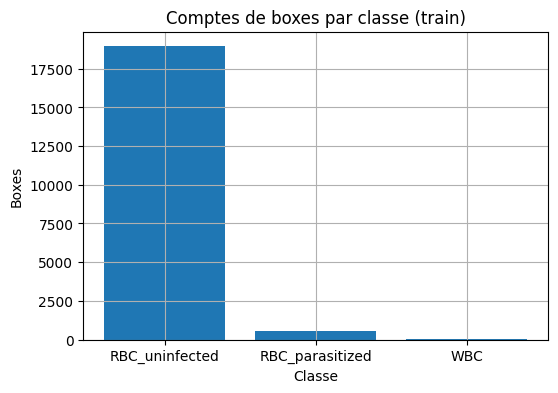

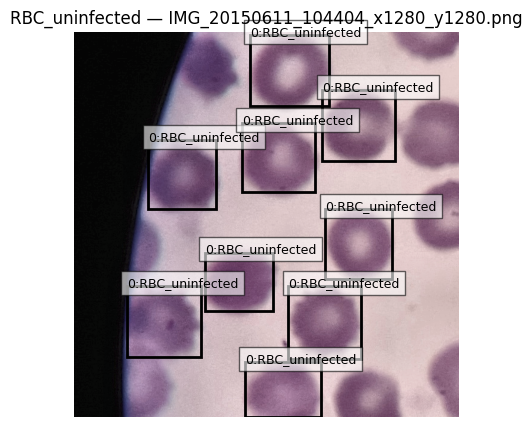

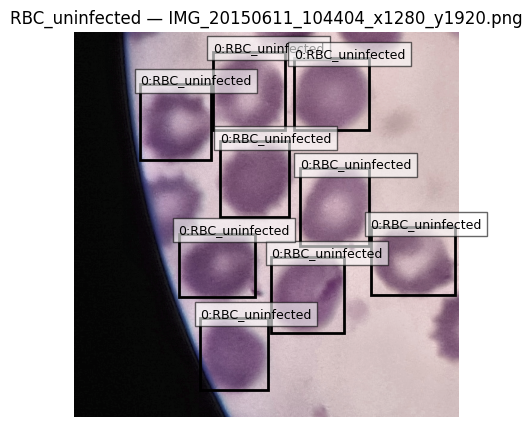

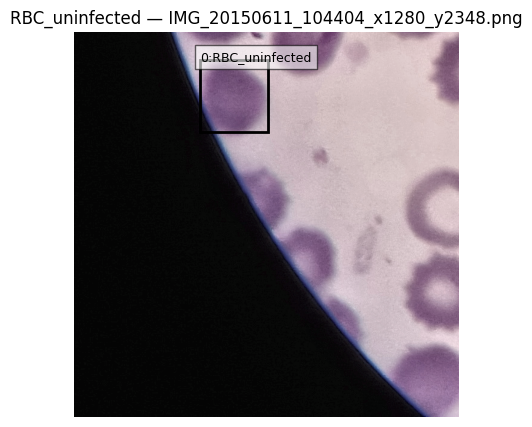

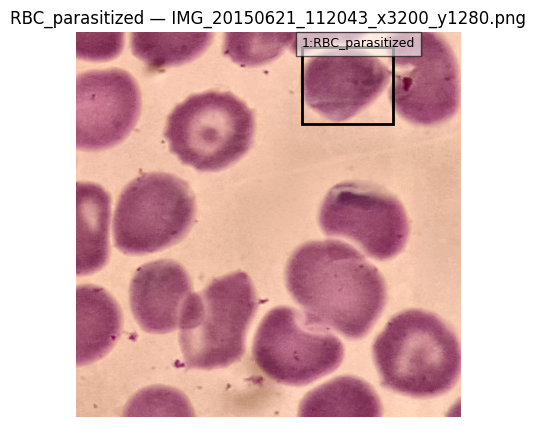

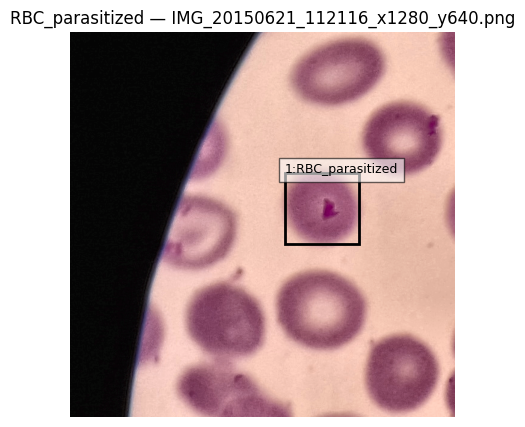

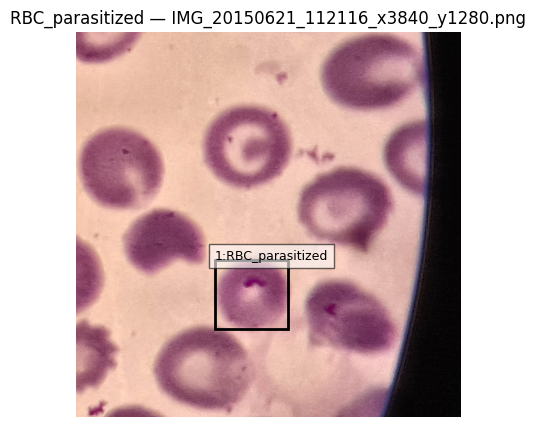

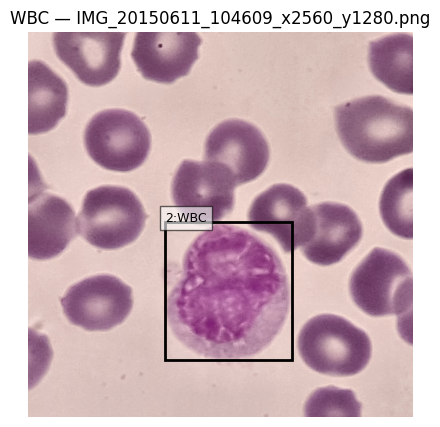

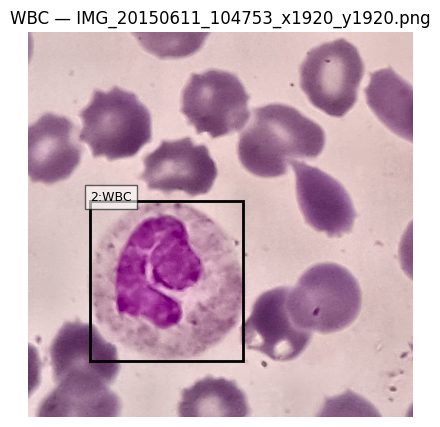

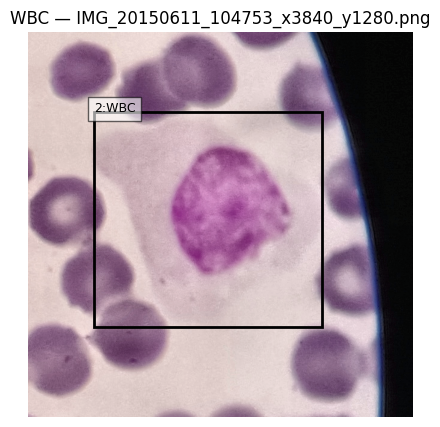

(5175, 900)

In [13]:
train_ds = YoloTileDataset(OUT, 'train', IMG_SIZE, aug=True,
                            use_clahe=USE_CLAHE, clahe_clip=CLAHE_CLIP, clahe_grid=CLAHE_TILE_GRID, clahe_space=CLAHE_SPACE)
val_ds   = YoloTileDataset(OUT, 'val', IMG_SIZE, aug=False,
                            use_clahe=USE_CLAHE, clahe_clip=CLAHE_CLIP, clahe_grid=CLAHE_TILE_GRID, clahe_space=CLAHE_SPACE)

# Stats classes
stats_df = train_ds.get_class_stats_df()
try:
    import ace_tools as tools
    tools.display_dataframe_to_user('Stats classes (train)', stats_df)
except Exception:
    display(stats_df)

# Bar chart des counts
plt.figure(figsize=(6,4))
plt.bar(stats_df['class_name'].values, stats_df['box_count'].values)
plt.title('Comptes de boxes par classe (train)'); plt.xlabel('Classe'); plt.ylabel('Boxes'); plt.grid(True)
plt.show()

# Visualiser quelques exemples par classe (après CLAHE)
train_ds.show_examples_per_class(k=3)

# DataLoaders (avec balancing optionnel)
def collate_fn(batch):
    imgs, labels, paths = zip(*batch)
    imgs = torch.stack(imgs, 0)
    new_labels = []
    for i, y in enumerate(labels):
        if y.numel():
            b = torch.full((y.size(0), 1), i, dtype=torch.float32)  # <— dtype explicite
            new_labels.append(torch.cat([b, y], 1))
    # <— dtype explicite, même quand il n'y a aucun label
    new_labels = torch.cat(new_labels, 0) if len(new_labels) else torch.zeros((0,6), dtype=torch.float32)
    return imgs, new_labels, paths


if BALANCE:
    sampler, weights_df = build_weighted_sampler(train_ds, alpha=OVERSAMPLE_ALPHA, weight_empty=WEIGHT_EMPTY)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True, collate_fn=collate_fn)
else:
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

len(train_ds), len(val_ds)

## 5) Cibles & pertes (anchor-free simple + GIoU)

In [14]:
def box_cxcywh_to_xyxy(box):
    cx, cy, w, h = box[...,0], box[...,1], box[...,2], box[...,3]
    x0 = cx - w/2; y0 = cy - h/2
    x1 = cx + w/2; y1 = cy + h/2
    return torch.stack([x0,y0,x1,y1], -1)

def box_iou_xyxy(box1, box2):
    area1 = (box1[:,2]-box1[:,0]).clamp(min=0) * (box1[:,3]-box1[:,1]).clamp(min=0)
    area2 = (box2[:,2]-box2[:,0]).clamp(min=0) * (box2[:,3]-box2[:,1]).clamp(min=0)
    lt = torch.max(box1[:,None,:2], box2[:,:2])
    rb = torch.min(box1[:,None,2:], box2[:,2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[...,0] * wh[...,1]
    union = area1[:,None] + area2 - inter + 1e-9
    return inter / union

def box_area_xyxy(b):
    return (b[:, 2] - b[:, 0]).clamp(min=0) * (b[:, 3] - b[:, 1]).clamp(min=0)

def giou_xyxy(box1, box2):
    """
    box1, box2: (N,4) xyxy, appariés 1–à–1
    Retourne GIoU dans [-1, 1].
    """
    # intersection
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])
    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)

    # union
    a1 = box_area_xyxy(box1)
    a2 = box_area_xyxy(box2)
    union = a1 + a2 - inter + 1e-9
    iou = inter / union

    # boîte englobante C
    cx1 = torch.min(box1[:, 0], box2[:, 0])
    cy1 = torch.min(box1[:, 1], box2[:, 1])
    cx2 = torch.max(box1[:, 2], box2[:, 2])
    cy2 = torch.max(box1[:, 3], box2[:, 3])
    c_area = (cx2 - cx1).clamp(min=0) * (cy2 - cy1).clamp(min=0) + 1e-9

    giou = iou - (c_area - union) / c_area
    return giou.clamp(min=-1.0, max=1.0)


def size_to_level(w, h):
    s = math.sqrt(max(1e-9, w*h)) * IMG_SIZE
    if s <= 64: return 0
    if s <= 128: return 1
    return 2

def build_targets(labels, batch_size, feats_shapes):
    B = batch_size
    C = NUM_CLASSES

    # Créer les tenseurs cibles
    reg_tgts = []; obj_tgts = []; cls_tgts = []; pos_masks = []
    for (H,W) in feats_shapes:
        reg_tgts.append(torch.zeros(B, 4, H, W, device=device))
        obj_tgts.append(torch.zeros(B, 1, H, W, device=device))
        cls_tgts.append(torch.zeros(B, C, H, W, device=device))
        pos_masks.append(torch.zeros(B, 1, H, W, device=device))

    if labels.numel() == 0:
        return reg_tgts, obj_tgts, cls_tgts, pos_masks

    # Filtrer les labels dont l'indice batch est hors [0, B-1]
    b_idx = labels[:, 0].long()
    valid = (b_idx >= 0) & (b_idx < B)
    if not valid.all():
        labels = labels[valid]
        if labels.numel() == 0:
            return reg_tgts, obj_tgts, cls_tgts, pos_masks

    for row in labels:
        b = int(row[0].item()); c = int(row[1].item())
        cx, cy, w, h = row[2:].tolist()
        lvl = size_to_level(w, h)
        H, W = feats_shapes[lvl]
        i = min(W-1, max(0, int(cx * W)))
        j = min(H-1, max(0, int(cy * H)))
        obj_tgts[lvl][b,0,j,i] = 1.0
        pos_masks[lvl][b,0,j,i] = 1.0
        reg_tgts[lvl][b,:,j,i] = torch.tensor([cx,cy,w,h], device=device)
        cls_tgts[lvl][b,c,j,i] = 1.0
    return reg_tgts, obj_tgts, cls_tgts, pos_masks

bce = nn.BCEWithLogitsLoss(reduction='none')

def loss_fn(outputs, labels):
    # 1) B doit venir des sorties (batch réel), pas des labels
    B = outputs[0].shape[0]
    feats_shapes = [(o.shape[2], o.shape[3]) for o in outputs]

    # 2) Construire les cibles avec le bon B (et filtrer les labels hors-batch si besoin)
    #    -> build_targets ci-dessous prend déjà B en argument
    reg_tgts, obj_tgts, cls_tgts, pos_masks = build_targets(labels, B, feats_shapes)

    L_box = torch.zeros((), device=outputs[0].device)
    L_obj = torch.zeros((), device=outputs[0].device)
    L_cls = torch.zeros((), device=outputs[0].device)
    n_pos = 0

    for l, out in enumerate(outputs):
        # out: [B, 4+1+nc, H, W]
        reg_pred = out[:, 0:4]   # [B,4,H,W]
        obj_pred = out[:, 4:5]   # [B,1,H,W]
        cls_pred = out[:, 5:]    # [B,C,H,W]

        reg_p = torch.sigmoid(reg_pred)

        # Masques & cibles alignés sur B
        pos = pos_masks[l].squeeze(1).bool()     # [B,H,W] bool
        obj_t = obj_tgts[l]                      # [B,1,H,W]
        cls_t = cls_tgts[l]                      # [B,C,H,W]

        # --- Loss box & cls: uniquement sur positifs ---
        if pos.any():
            n_pos += int(pos.sum().item())

            # Aplatissement implicite par indexing booléen sur [B,H,W]
            reg_p_pos = reg_p.permute(0,2,3,1)[pos]      
            reg_t_pos = reg_tgts[l].permute(0,2,3,1)[pos]

            b1 = box_cxcywh_to_xyxy(reg_p_pos)
            b2 = box_cxcywh_to_xyxy(reg_t_pos)

            giou = giou_xyxy(b1, b2)             
            L_box += torch.clamp_min(1.0 - giou, 0.0).mean()


            cls_p_pos = cls_pred.permute(0,2,3,1)[pos]   # [Npos, C]
            cls_t_pos = cls_t.permute(0,2,3,1)[pos]      # [Npos, C]
            L_cls = L_cls + bce(cls_p_pos, cls_t_pos).mean()

        # --- Loss obj: sur tout le grid ---
        L_obj = L_obj + bce(obj_pred, obj_t).mean()

    L = WEIGHTS['box']*L_box + WEIGHTS['obj']*L_obj + WEIGHTS['cls']*L_cls
    return L, {'L_box': float(L_box.item()), 'L_obj': float(L_obj.item()), 'L_cls': float(L_cls.item()), 'n_pos': n_pos}


## 6) Inference → NMS → mAP50 / mAP50–95

In [15]:
def nms(boxes, scores, iou_th=0.5, max_det=300):
    idxs = scores.argsort(descending=True)
    keep = []
    while idxs.numel() > 0 and len(keep) < max_det:
        i = idxs[0]
        keep.append(i.item())
        if idxs.numel() == 1: break
        cur = boxes[i].unsqueeze(0)
        rest = boxes[idxs[1:]]
        lt = torch.max(cur[:,:2], rest[:,:2])
        rb = torch.min(cur[:,2:], rest[:,2:])
        wh = (rb - lt).clamp(min=0)
        inter = wh[:,0] * wh[:,1]
        area1 = (cur[:,2]-cur[:,0])*(cur[:,3]-cur[:,1])
        area2 = (rest[:,2]-rest[:,0])*(rest[:,3]-rest[:,1])
        union = area1 + area2 - inter + 1e-9
        ious = inter / union
        idxs = idxs[1:][ious <= iou_th]
    return torch.tensor(keep, device=boxes.device, dtype=torch.long)

@torch.no_grad()
def predict_batch(model, imgs):
    model.eval()
    outs = model(imgs)
    preds = []
    for out in outs:
        B, C, H, W = out.shape
        reg = torch.sigmoid(out[:,0:4])
        obj = torch.sigmoid(out[:,4:5])
        cls = torch.sigmoid(out[:,5:])
        reg = reg.permute(0,2,3,1).reshape(B, H*W, 4)
        obj = obj.permute(0,2,3,1).reshape(B, H*W, 1)
        cls = cls.permute(0,2,3,1).reshape(B, H*W, NUM_CLASSES)
        preds.append((reg,obj,cls))
    return preds

@torch.no_grad()
def infer_and_nms(model, imgs, conf_th=0.25, iou_th=0.5, max_det=300):
    B = imgs.size(0)
    preds = predict_batch(model, imgs)
    final = []
    for b in range(B):
        boxes_all = []; scores_all = []; labels_all = []
        for (reg,obj,cls) in preds:
            r = reg[b]; o = obj[b]; c = cls[b]
            s = (o * c)
            smax, lab = s.max(dim=1)
            m = smax > conf_th
            if m.sum() == 0: continue
            r = r[m]; smax = smax[m]; lab = lab[m]
            bxyxy = box_cxcywh_to_xyxy(r) * IMG_SIZE
            boxes_all.append(bxyxy); scores_all.append(smax); labels_all.append(lab)
        if len(boxes_all)==0:
            final.append({'boxes': torch.zeros((0,4), device=imgs.device), 'scores': torch.zeros((0,), device=imgs.device), 'labels': torch.zeros((0,), dtype=torch.long, device=imgs.device)})
            continue
        boxes_all = torch.cat(boxes_all, 0)
        scores_all = torch.cat(scores_all, 0)
        labels_all = torch.cat(labels_all, 0)
        keep_total = []
        for c in range(NUM_CLASSES):
            mask = labels_all==c
            if mask.sum()==0: continue
            k = nms(boxes_all[mask], scores_all[mask], iou_th=iou_th, max_det=max_det)
            keep_idx = torch.nonzero(mask, as_tuple=False).squeeze(1)[k]
            keep_total.append(keep_idx)
        if keep_total:
            keep_total = torch.cat(keep_total, 0)
            final.append({'boxes': boxes_all[keep_total], 'scores': scores_all[keep_total], 'labels': labels_all[keep_total]})
        else:
            final.append({'boxes': torch.zeros((0,4), device=imgs.device), 'scores': torch.zeros((0,), device=imgs.device), 'labels': torch.zeros((0,), dtype=torch.long, device=imgs.device)})
    return final

def compute_ap(recall, precision):
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


@torch.no_grad()
def evaluate_map(model, loader, iou_thresholds=np.arange(0.5, 0.96, 0.05), conf_th=0.5, progress=False):
    model.eval()
    all_dets = []; all_gts  = []

    it = tqdm(loader, desc="Validate", leave=False) if progress else loader
    for imgs, labels, paths in it:
        imgs = imgs.to(DEVICE)
        dets = infer_and_nms(model, imgs, conf_th=conf_th, iou_th=0.50, max_det=300)
        for b in range(imgs.size(0)):
            all_dets.append({
                'boxes': dets[b]['boxes'].cpu().numpy(),
                'scores': dets[b]['scores'].cpu().numpy(),
                'labels': dets[b]['labels'].cpu().numpy().astype(int)
            })
        if labels.numel():
            for b in range(imgs.size(0)):
                m = labels[:,0]==b
                yb = labels[m][:,1:]
                if yb.numel():
                    xyxy = box_cxcywh_to_xyxy(yb[:,1:]) * IMG_SIZE
                    all_gts.append({'boxes': xyxy.cpu().numpy(), 'labels': yb[:,0].cpu().numpy().astype(int)})
                else:
                    all_gts.append({'boxes': np.zeros((0,4)), 'labels': np.zeros((0,), dtype=int)})
        else:
            for b in range(imgs.size(0)):
                all_gts.append({'boxes': np.zeros((0,4)), 'labels': np.zeros((0,), dtype=int)})
    
    aps_50_95 = []; aps_50 = []
    for c in range(NUM_CLASSES):
        preds = []; gts = []
        for i in range(len(all_dets)):
            m = (all_dets[i]['labels'] == c)
            boxes = all_dets[i]['boxes'][m]
            scores = all_dets[i]['scores'][m]
            preds.append((boxes, scores, i))
            mg = (all_gts[i]['labels'] == c)
            gts.append(all_gts[i]['boxes'][mg])
        preds = [(b,s,i) for (b,s,i) in preds if b.shape[0]>0]
        if len(preds)==0:
            aps_50_95.append(0.0); aps_50.append(0.0); continue
        order = np.argsort(-np.concatenate([p[1] for p in preds]))
        boxes_all = np.concatenate([p[0] for p in preds], axis=0)
        scores_all = np.concatenate([p[1] for p in preds], axis=0)
        img_ids = np.concatenate([[p[2]]*len(p[1]) for p in preds])
        boxes_all = boxes_all[order]; scores_all = scores_all[order]; img_ids = img_ids[order]
        gt_used = [np.zeros((gts[i].shape[0],), dtype=bool) for i in range(len(gts))]
        ap_list = []
        for thr in iou_thresholds:
            tp = np.zeros((len(boxes_all),), dtype=float)
            fp = np.zeros((len(boxes_all),), dtype=float)
            for k in range(len(boxes_all)):
                i = img_ids[k]; b = boxes_all[k]
                best_iou, best_j = 0.0, -1
                for j in range(gts[i].shape[0]):
                    if gt_used[i][j]: continue
                    bb = gts[i][j]
                    inter_x1 = max(b[0], bb[0]); inter_y1 = max(b[1], bb[1])
                    inter_x2 = min(b[2], bb[2]); inter_y2 = min(b[3], bb[3])
                    inter = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
                    area_b = max(0, b[2]-b[0]) * max(0, b[3]-b[1])
                    area_bb = max(0, bb[2]-bb[0]) * max(0, bb[3]-bb[1])
                    union = area_b + area_bb - inter + 1e-9
                    iou = inter / union
                    if iou > best_iou:
                        best_iou, best_j = iou, j
                if best_iou >= thr and best_j >= 0:
                    tp[k] = 1.0; gt_used[i][best_j] = True
                else:
                    fp[k] = 1.0
            fp_cum = np.cumsum(fp); tp_cum = np.cumsum(tp)
            recall = tp_cum / max(1, sum(len(x) for x in gts))
            precision = tp_cum / np.maximum(tp_cum + fp_cum, 1e-9)
            ap = compute_ap(recall, precision)
            ap_list.append(ap)
        aps_50_95.append(float(np.mean(ap_list)))
        aps_50.append(float(ap_list[0]))
    mAP50_95 = float(np.mean(aps_50_95))
    mAP50 = float(np.mean(aps_50))
    return {'mAP50': mAP50, 'mAP50_95': mAP50_95}

## 7) Entraînement YOLOKAN11 (KAN)

### 1) Import

In [16]:
from tqdm.auto import tqdm
from contextlib import nullcontext

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# AMP (API moderne torch.amp)
if DEVICE == 'cuda' and torch.cuda.is_bf16_supported():
    AMP_DTYPE = torch.bfloat16
else:
    AMP_DTYPE = torch.float16

scaler = torch.amp.GradScaler(device=DEVICE, enabled=(DEVICE == 'cuda'))


In [17]:
import os, torch, random
import numpy as np

CKPT_PATH = SAVE_DIR/'checkpoint.pth'   # état complet (model+opt+scaler+epoch+best+métriques)
BEST_WEIGHTS = SAVE_DIR/'kan_best.pt'   # uniquement poids
LAST_WEIGHTS = SAVE_DIR/'kan_last.pt'   # uniquement poids

def save_checkpoint(epoch, model, opt, scaler, best_map, history):
    ckpt = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': opt.state_dict(),
        'scaler': scaler.state_dict() if scaler is not None else None,
        'best_map': best_map,
        'history': history,  # tu peux aussi ne pas l’inclure si le CSV te suffit
        # états RNG pour exact resume
        'rng': {
            'torch': torch.get_rng_state(),
            'cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
            'np': np.random.get_state(),
            'py': random.getstate(),
        }
    }
    torch.save(ckpt, CKPT_PATH)





import pickle, numpy as np, warnings
from torch.serialization import add_safe_globals

# ---------- utils RNG sûrs ----------
def _to_byte_cpu(x):
    """Convertit divers formats vers ByteTensor sur CPU, sinon None."""
    if isinstance(x, torch.ByteTensor):
        return x.cpu()
    if isinstance(x, torch.Tensor):
        return x.detach().to('cpu', dtype=torch.uint8).contiguous()
    if isinstance(x, np.ndarray):
        return torch.from_numpy(x.astype(np.uint8, copy=False)).cpu()
    if isinstance(x, (bytes, bytearray)):
        return torch.tensor(list(x), dtype=torch.uint8)
    if isinstance(x, (list, tuple)):
        try:
            return torch.tensor(x, dtype=torch.uint8)
        except Exception:
            return None
    return None

def _restore_rng_safe(rng_dict, device_str='cpu'):
    """Restaure les RNG; ignore proprement si format/taille invalides."""
    if not rng_dict:
        return

    # --- CPU RNG ---
    proto = torch.get_rng_state()            # ByteTensor CPU de référence
    t = _to_byte_cpu(rng_dict.get('torch', None))
    if t is not None and t.dtype == torch.uint8 and t.numel() == proto.numel():
        try:
            torch.set_rng_state(t)
        except Exception as e:
            warnings.warn(f"Skip CPU RNG restore: {e}")
    else:
        warnings.warn("Skip CPU RNG: invalid dtype/size")

    # --- CUDA RNG ---
    if device_str == 'cuda' and torch.cuda.is_available() and rng_dict.get('cuda', None) is not None:
        try:
            proto_list = torch.cuda.get_rng_state_all()  # liste par device
            states_in = rng_dict['cuda']
            if isinstance(states_in, (list, tuple)) and len(states_in) == len(proto_list):
                ok = True
                converted = []
                for s, proto_s in zip(states_in, proto_list):
                    cs = _to_byte_cpu(s)
                    if cs is None or cs.dtype != torch.uint8 or cs.numel() != proto_s.numel():
                        ok = False; break
                    converted.append(cs)
                if ok:
                    torch.cuda.set_rng_state_all(converted)
                else:
                    warnings.warn("Skip CUDA RNG: invalid list elements")
            else:
                warnings.warn("Skip CUDA RNG: invalid list length/type")
        except Exception as e:
            warnings.warn(f"Skip CUDA RNG restore: {e}")

    # --- NumPy RNG ---
    if rng_dict.get('np', None) is not None:
        try:
            np.random.set_state(rng_dict['np'])
        except Exception:
            warnings.warn("Skip NumPy RNG (invalid state)")

    # --- Python RNG ---
    if rng_dict.get('py', None) is not None:
        try:
            random.setstate(rng_dict['py'])
        except Exception:
            warnings.warn("Skip Python RNG (invalid state)")

# ---------- load checkpoint sûr ----------
def _load_ckpt_full(path, map_location):
    # PyTorch 2.6 : weights_only=False pour un checkpoint complet
    try:
        return torch.load(path, map_location=map_location, weights_only=False)
    except pickle.UnpicklingError:
        # allowlist pour anciens pickles numpy
        add_safe_globals([np.core.multiarray._reconstruct])
        return torch.load(path, map_location=map_location, weights_only=False)

def load_checkpoint(model, opt=None, scaler=None, scheduler=None, ema=None, map_location='cpu', restore_rng=True):
    ckpt = _load_ckpt_full(CKPT_PATH, map_location)

    # Poids modèle
    model.load_state_dict(ckpt['model'], strict=True)

    # Optim/Scaler/Scheduler/EMA si présents
    if opt is not None and ckpt.get('optimizer') is not None:
        opt.load_state_dict(ckpt['optimizer'])
    if scaler is not None and ckpt.get('scaler') is not None:
        scaler.load_state_dict(ckpt['scaler'])
    if scheduler is not None and ckpt.get('scheduler') is not None:
        scheduler.load_state_dict(ckpt['scheduler'])
    if ema is not None and ckpt.get('ema') is not None:
        ema.load_state_dict(ckpt['ema'])

    # RNG (optionnel et sûr)
    if restore_rng:
        _restore_rng_safe(ckpt.get('rng', {}), device_str=('cuda' if torch.cuda.is_available() else 'cpu'))

    start_epoch = int(ckpt.get('epoch', 0)) + 1
    best_map = float(ckpt.get('best_map', -1.0))
    history = ckpt.get('history', [])
    return start_epoch, best_map, history



In [18]:
# (option) forcer un chemin de reprise :
RESUME_FROM = "/kaggle/working/nih_yolo/yolokan11_runs/checkpoint.pth"  # ex: Path('/kaggle/working/nih_yolo/yolokan11_runs/checkpoint.pth') ou 'last'/'best'/None

model = YOLOKAN11(nc=NUM_CLASSES, degree=DEGREE, width_multiple=WIDTH_MULT, depth_multiple=DEPTH_MULT).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-2)

# AMP context/scaler déjà définis plus haut :
# DEVICE, AMP_DTYPE, scaler = torch.amp.GradScaler(device=DEVICE, enabled=(DEVICE=='cuda'))

start_epoch = 1
best_map = -1.0
history = []

# Politique de reprise
resume_path = None
if RESUME_FROM is None:
    # auto: si checkpoint complet existe, on le charge
    if CKPT_PATH.exists():
        resume_path = CKPT_PATH
elif str(RESUME_FROM).lower() == 'last':
    resume_path = CKPT_PATH if CKPT_PATH.exists() else (LAST_WEIGHTS if LAST_WEIGHTS.exists() else None)
elif str(RESUME_FROM).lower() == 'best':
    resume_path = BEST_WEIGHTS if BEST_WEIGHTS.exists() else None
else:
    resume_path = Path(RESUME_FROM)

if resume_path is not None and Path(resume_path).suffix == '.pth':
    # Reprendre l'entraînement COMPLET
    print(f"[Resume] Chargement checkpoint complet: {resume_path}")
    start_epoch, best_map, history = load_checkpoint(model, opt=opt, scaler=scaler, map_location=DEVICE, restore_rng=False)
elif resume_path is not None and Path(resume_path).suffix == '.pt':
    # Reprendre à partir des POIDS UNIQUEMENT (optimizer neuf)
    print(f"[Warm start] Chargement des poids: {resume_path}")
    sd = torch.load(resume_path, map_location=DEVICE)
    model.load_state_dict(sd, strict=True)
    # start_epoch reste 1 (ou choisis 0), best_map reste -1 sauf si tu veux le forcer
else:
    print("[Init] Entraînement from scratch")

print(f"Reprise à l'époque: {start_epoch} | Best mAP50-95: {best_map}")


[Resume] Chargement checkpoint complet: /kaggle/working/nih_yolo/yolokan11_runs/checkpoint.pth


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/nih_yolo/yolokan11_runs/checkpoint.pth'

In [ ]:
#model = YOLOKAN11(nc=NUM_CLASSES, degree=DEGREE, width_multiple=WIDTH_MULT, depth_multiple=DEPTH_MULT).to(DEVICE)
#opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-2)

#history = []
#best_map = -1.0
best_path = SAVE_DIR/'kan_best.pt'
last_path = SAVE_DIR/'kan_last.pt'
EPOCHS = 100
print('Entraînement Start :')
for epoch in tqdm(range(start_epoch, EPOCHS+1), desc="Epochs", leave=True):
    model.train()
    t0 = time.time()
    loss_sum = 0.0
    box_sum = obj_sum = cls_sum = 0.0
    pos_sum = 0

    amp_ctx = torch.amp.autocast(device_type=DEVICE, dtype=AMP_DTYPE) if DEVICE == 'cuda' else nullcontext()

    pbar = tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}", leave=False)
    for imgs, labels, paths in pbar:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        with amp_ctx:
            outs = model(imgs)
            loss, parts = loss_fn(outs, labels)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        # accumulate
        loss_sum += float(loss.item())
        box_sum  += parts['L_box']
        obj_sum  += parts['L_obj']
        cls_sum  += parts['L_cls']
        pos_sum  += parts['n_pos']

        pbar.set_postfix(loss=f"{loss_sum/(len(history)+1):.4f}", box=f"{parts['L_box']:.3f}",
                         obj=f"{parts['L_obj']:.3f}", cls=f"{parts['L_cls']:.3f}", pos=parts['n_pos'])

    # Validation (avec barre)
    metrics = {'mAP50': None, 'mAP50_95': None}
    if epoch % VAL_EVERY == 0:
        metrics = evaluate_map(model, val_loader, iou_thresholds=np.arange(0.5,0.96,0.05),
                               conf_th=0.25, progress=True)
        if metrics['mAP50_95'] is not None and metrics['mAP50_95'] > best_map:
            best_map = metrics['mAP50_95']
            torch.save(model.state_dict(), best_path)

    # Sauvegardes : poids + checkpoint complet
    torch.save(model.state_dict(), last_path)  # kan_last.pt (poids)
    if metrics['mAP50_95'] is not None and metrics['mAP50_95'] > best_map:
        best_map = metrics['mAP50_95']
        torch.save(model.state_dict(), best_path)  # kan_best.pt (poids)
    
    # Sauvegarde checkpoint complet (reprise exacte)
    save_checkpoint(epoch, model, opt, scaler, best_map, history)
    dt = time.time() - t0

    rec = {
        'epoch': epoch,
        'loss': loss_sum/len(train_loader),
        'L_box': box_sum/len(train_loader),
        'L_obj': obj_sum/len(train_loader),
        'L_cls': cls_sum/len(train_loader),
        'n_pos_per_it': pos_sum/max(1,len(train_loader)),
        'mAP50': metrics['mAP50'],
        'mAP50_95': metrics['mAP50_95'],
        'dt_s': dt
    }
    history.append(rec)

    # résumé epoch
    tqdm.write(f"[Epoch {epoch}/{EPOCHS}] loss={rec['loss']:.4f} | "
               f"box={rec['L_box']:.3f} obj={rec['L_obj']:.3f} cls={rec['L_cls']:.3f} | "
               f"mAP50={rec['mAP50']} mAP50-95={rec['mAP50_95']} | {dt:.1f}s")

df_hist = pd.DataFrame(history); df_hist.to_csv(SAVE_DIR/'kan_results.csv', index=False)
print('Entraînement terminé. Best mAP50-95 =', best_map, '\nBest:', best_path, '\nLast:', last_path)


In [ ]:
'''model = YOLOKAN11(nc=NUM_CLASSES, degree=DEGREE, width_multiple=WIDTH_MULT, depth_multiple=DEPTH_MULT).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=5e-2)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2) Choisir un dtype AMP (BF16 si dispo, sinon FP16)
if DEVICE == 'cuda' and torch.cuda.is_bf16_supported():
    AMP_DTYPE = torch.bfloat16
else:
    AMP_DTYPE = torch.float16

# 3) Nouveau GradScaler (torch.amp)
scaler = torch.amp.GradScaler(device=DEVICE, enabled=(DEVICE == 'cuda'))

history = []
best_map = -1.0
best_path = SAVE_DIR/'kan_best.pt'
last_path = SAVE_DIR/'kan_last.pt'
print('Entraînement Start :')
for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    loss_sum = 0.0
    box_sum = obj_sum = cls_sum = 0.0
    pos_sum = 0
    for imgs, labels, paths in train_loader:
        imgs = imgs.to(device); labels = labels.to(device)
        opt.zero_grad(set_to_none=True)
        
        amp_ctx = torch.amp.autocast(device_type=DEVICE, dtype=AMP_DTYPE) if DEVICE == 'cuda' else nullcontext()
        
        for imgs, labels, paths in train_loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with amp_ctx:
                outs = model(imgs)
                loss, parts = loss_fn(outs, labels)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        loss_sum += float(loss.item())
        box_sum += parts['L_box']; obj_sum += parts['L_obj']; cls_sum += parts['L_cls']; pos_sum += parts['n_pos']
    metrics = {'mAP50': None, 'mAP50_95': None}
    if epoch % VAL_EVERY == 0:
        metrics = evaluate_map(model, val_loader, iou_thresholds=np.arange(0.5,0.96,0.05), conf_th=0.001)
        if metrics['mAP50_95'] is not None and metrics['mAP50_95'] > best_map:
            best_map = metrics['mAP50_95']; torch.save(model.state_dict(), best_path)
    torch.save(model.state_dict(), last_path)
    dt = time.time() - t0
    rec = {'epoch': epoch, 'loss': loss_sum/len(train_loader), 'L_box': box_sum/len(train_loader), 'L_obj': obj_sum/len(train_loader), 'L_cls': cls_sum/len(train_loader), 'n_pos_per_it': pos_sum/max(1,len(train_loader)), 'mAP50': metrics['mAP50'], 'mAP50_95': metrics['mAP50_95'], 'dt_s': dt}
    history.append(rec)
    print(f"[Epoch {epoch}/{EPOCHS}] loss={rec['loss']:.4f} | box={rec['L_box']:.3f} obj={rec['L_obj']:.3f} cls={rec['L_cls']:.3f} | mAP50={rec['mAP50']} mAP50-95={rec['mAP50_95']} | {dt:.1f}s")

df_hist = pd.DataFrame(history); df_hist.to_csv(SAVE_DIR/'kan_results.csv', index=False)
print('Entraînement terminé. Best mAP50-95 =', best_map, '\nBest:', best_path, '\nLast:', last_path)'''

## 8) Convergence, latence & visualisations

In [ ]:
def convergence_stats_from_csv(csv_path, key='mAP50_95'):
    df = pd.read_csv(csv_path)
    if key not in df.columns: return None
    s = df[key].fillna(0.0).values
    best = float(np.nanmax(s)); e_best = int(np.nanargmax(s)+1)
    thr80 = 0.80 * best; thr95 = 0.95 * best
    def ttf(thr):
        idx = np.where(s >= thr)[0]
        return int(idx[0]+1) if len(idx) else None
    t80 = ttf(thr80); t95 = ttf(thr95)
    auc = float(np.trapz(s, dx=1)) / max(1, len(s))
    return {'best_mAP50_95': best, 'epoch_best': e_best, 'TTF80_epochs': t80, 'TTF95_epochs': t95, 'AUC_mAP_per_epoch': auc}

@torch.no_grad()
def inference_latency(model, imgsz=640, n_warmup=10, n_iters=50):
    model.eval()
    x = torch.randint(0, 255, (1,3,imgsz,imgsz), dtype=torch.uint8, device=DEVICE).float()/255.0

    for _ in tqdm(range(n_warmup), desc="Warmup", leave=False):
        _ = infer_and_nms(model, x, conf_th=0.25, iou_th=0.5, max_det=300)
    if DEVICE != 'cpu': torch.cuda.synchronize()

    t0 = time.time()
    for _ in tqdm(range(n_iters), desc="Benchmark", leave=False):
        _ = infer_and_nms(model, x, conf_th=0.25, iou_th=0.5, max_det=300)
    if DEVICE != 'cpu': torch.cuda.synchronize()

    dt = (time.time() - t0)/n_iters
    return {'ms_per_img': dt*1000.0, 'img_per_sec': 1.0/dt}


conv = convergence_stats_from_csv(SAVE_DIR/'kan_results.csv')
lat = inference_latency(model)

try:
    import ace_tools as tools
    if conv: tools.display_dataframe_to_user('Convergence (YOLOKAN11)', pd.DataFrame([conv]))
    tools.display_dataframe_to_user('Latence (YOLOKAN11)', pd.DataFrame([lat]))
except Exception:
    if conv: display(pd.DataFrame([conv]))
    display(pd.DataFrame([lat]))

# Courbes
df = pd.read_csv(SAVE_DIR/'kan_results.csv')
plt.figure(figsize=(7,4))
plt.plot(df['epoch'], df['mAP50_95'].fillna(0.0).values)
plt.xlabel('epoch'); plt.ylabel('mAP50-95'); plt.title('Courbe mAP50-95 (validation)'); plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(df['epoch'], df['L_box'].values); plt.plot(df['epoch'], df['L_obj'].values); plt.plot(df['epoch'], df['L_cls'].values)
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Loss components'); plt.grid(True)
plt.legend(['L_box','L_obj','L_cls'])
plt.show()

In [ ]:
# =========================
# Visualisation de prédictions YOLOKAN11
# =========================
import torch, math, os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.ops import nms

# --- Paramètres ---
IMG_SIZE = 640
CLASS_NAMES = ['Uninfected', 'Parasitized', 'White_Blood_Cell']  # adapte si besoin
NUM_CLASSES = len(CLASS_NAMES)

# Couleurs par classe (RGB)
COLORS = {
    0: (0, 180/255, 1.0),     # Uninfected - bleu
    1: (1.0, 120/255, 0.0),   # Parasitized - orange
    2: (0.1, 0.8, 0.1),       # WBC - vert
}

# Dossier de sortie des visualisations
VIS_DIR = Path(SAVE_DIR) / "preds_vis"
VIS_DIR.mkdir(parents=True, exist_ok=True)

def cxcywh_to_xyxy(boxes):
    # boxes: (N,4) in [0,1] relative to image size
    cx, cy, w, h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    x0 = (cx - w/2) * IMG_SIZE
    y0 = (cy - h/2) * IMG_SIZE
    x1 = (cx + w/2) * IMG_SIZE
    y1 = (cy + h/2) * IMG_SIZE
    return torch.stack([x0,y0,x1,y1], dim=1)

def decode_outputs(outputs, conf_th=0.25, iou_nms=0.5, max_det=300):
    """
    outputs: list of 3 [B, 5+nc, H, W]
    Retourne une liste de longueur B, chaque élément un dict:
      {'boxes':(N,4 xyxy), 'scores':(N,), 'labels':(N,)}
    """
    B = outputs[0].shape[0]
    device = outputs[0].device
    decoded = [{'boxes': [], 'scores': [], 'labels': []} for _ in range(B)]

    all_boxes = [[] for _ in range(B)]
    all_scores = [[] for _ in range(B)]
    all_labels = [[] for _ in range(B)]

    for out in outputs:
        reg = torch.sigmoid(out[:, 0:4, ...])     # [B,4,H,W] in [0,1]
        obj = torch.sigmoid(out[:, 4:5, ...])     # [B,1,H,W]
        cls = torch.sigmoid(out[:, 5: , ...])     # [B,C,H,W]

        B_, _, H, W = out.shape
        # flatten grid
        reg_f = reg.permute(0,2,3,1).reshape(B_, H*W, 4)    # [B,HW,4]
        obj_f = obj.permute(0,2,3,1).reshape(B_, H*W, 1)    # [B,HW,1]
        cls_f = cls.permute(0,2,3,1).reshape(B_, H*W, NUM_CLASSES)  # [B,HW,C]

        # score = obj * cls
        scores = obj_f * cls_f  # [B,HW,C]

        # filtre conf
        for b in range(B_):
            s_b = scores[b]      # [HW, C]
            reg_b = reg_f[b]     # [HW, 4]

            # pour chaque classe, sélection des indices au-dessus du seuil
            for c in range(NUM_CLASSES):
                sc = s_b[:, c]   # [HW]
                keep = sc > conf_th
                if keep.any():
                    boxes_c = reg_b[keep]              # cxcywh
                    boxes_c = cxcywh_to_xyxy(boxes_c)  # xyxy [pixels]
                    scores_c = sc[keep]
                    labels_c = torch.full_like(scores_c, c, dtype=torch.long)

                    all_boxes[b].append(boxes_c)
                    all_scores[b].append(scores_c)
                    all_labels[b].append(labels_c)

    # concat & NMS
    results = []
    for b in range(B):
        if len(all_boxes[b]) == 0:
            results.append({'boxes': torch.zeros((0,4)), 'scores': torch.zeros((0,)), 'labels': torch.zeros((0,), dtype=torch.long)})
            continue
        boxes = torch.cat(all_boxes[b], dim=0)
        scores = torch.cat(all_scores[b], dim=0)
        labels = torch.cat(all_labels[b], dim=0)

        # NMS par classe (class-wise)
        final_boxes = []
        final_scores = []
        final_labels = []
        for c in range(NUM_CLASSES):
            idx = (labels == c).nonzero(as_tuple=False).squeeze(1)
            if idx.numel() == 0:
                continue
            b_c = boxes[idx]
            s_c = scores[idx]
            keep_idx = nms(b_c, s_c, iou_nms)
            keep_idx = keep_idx[:max_det]
            final_boxes.append(b_c[keep_idx])
            final_scores.append(s_c[keep_idx])
            final_labels.append(torch.full((keep_idx.numel(),), c, dtype=torch.long, device=boxes.device))

        if len(final_boxes) == 0:
            results.append({'boxes': torch.zeros((0,4)), 'scores': torch.zeros((0,)), 'labels': torch.zeros((0,), dtype=torch.long)})
        else:
            boxes_f = torch.cat(final_boxes, dim=0)
            scores_f = torch.cat(final_scores, dim=0)
            labels_f = torch.cat(final_labels, dim=0)
            results.append({'boxes': boxes_f.cpu(), 'scores': scores_f.cpu(), 'labels': labels_f.cpu()})

    return results

def draw_boxes(ax, img, boxes, scores=None, labels=None, show_scores=True, linewidth=2):
    ax.imshow(img)
    if boxes is None or len(boxes)==0:
        ax.axis('off')
        return
    for i, box in enumerate(boxes):
        x0,y0,x1,y1 = box
        c = int(labels[i]) if labels is not None else 0
        color = COLORS.get(c, (1.0, 0.0, 0.0))
        rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(rect)
        text = CLASS_NAMES[c]
        if show_scores and scores is not None:
            text += f" {float(scores[i]):.2f}"
        ax.text(x0, y0-2, text, fontsize=9, color='white',
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1.5))
    ax.axis('off')

def yolo_targets_to_xyxy(targets):
    """
    targets: Tensor [N,5] (b, cls, cx, cy, w, h) normalisés [0,1]
    Retourne dict{b: (boxes_xyxy, labels)}
    """
    if targets is None or targets.numel()==0:
        return {}
    out = {}
    b = targets[:,0].long()
    c = targets[:,1].long()
    boxes = cxcywh_to_xyxy(targets[:,2:6])
    for i in range(b.max().item()+1):
        m = (b==i)
        out[int(i)] = (boxes[m].cpu(), c[m].cpu())
    return out

@torch.no_grad()
def visualize_batch(model, batch, save_path, conf_th=0.25, iou_nms=0.5, show_gt=True, max_imgs=8):
    """
    batch: (imgs, labels, paths) tel que renvoyé par le DataLoader
    """
    model.eval()
    imgs, labels, paths = batch
    imgs = imgs.to(next(model.parameters()).device)
    outs = model(imgs)
    preds = decode_outputs(outs, conf_th=conf_th, iou_nms=iou_nms)

    # GT par image
    gt_by_b = yolo_targets_to_xyxy(labels)

    B = imgs.shape[0]
    n = min(B, max_imgs)
    cols = 2 if show_gt else 1
    fig, axes = plt.subplots(nrows=n, ncols=cols, figsize=(8*cols, 6*n))
    if n == 1 and cols == 1:
        axes = np.array([[axes]])
    elif n == 1 and cols == 2:
        axes = np.array([axes])

    for i in range(n):
        img_np = (imgs[i].permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
        # prédiction
        axp = axes[i,0] if cols==2 else axes[i]
        pb = preds[i]
        draw_boxes(axp, img_np, pb['boxes'].numpy(), pb['scores'].numpy(), pb['labels'].numpy(), show_scores=True)
        axp.set_title(f"Pred: {Path(paths[i]).name}")

        if show_gt:
            axg = axes[i,1]
            if i in gt_by_b:
                b_gt, l_gt = gt_by_b[i]
                draw_boxes(axg, img_np, b_gt.numpy(), scores=None, labels=l_gt.numpy(), show_scores=False)
            else:
                draw_boxes(axg, img_np, np.zeros((0,4)))
            axg.set_title("Ground Truth")

    plt.tight_layout()
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

@torch.no_grad()
def visualize_predictions(model, loader, num_batches=2, conf_th=0.25, iou_nms=0.5, show_gt=True):
    """
    Parcourt quelques batches du loader et sauvegarde des planches d'images avec boîtes.
    """
    device = next(model.parameters()).device
    model.eval()
    saved_files = []
    it = 0
    for batch in loader:
        it += 1
        out_path = VIS_DIR / f"vis_batch_{it:03d}.png"
        visualize_batch(model, batch, save_path=out_path, conf_th=conf_th, iou_nms=iou_nms, show_gt=show_gt, max_imgs=6)
        saved_files.append(out_path)
        if it >= num_batches:
            break
    print(f"Visualisations sauvegardées dans: {VIS_DIR}")
    return saved_files


In [ ]:
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt if isinstance(ckpt, dict) and 'model' not in ckpt else ckpt.get('model', ckpt), strict=True)
model.to(DEVICE).eval()


In [ ]:
saved = visualize_predictions(model, val_loader, num_batches=3, conf_th=0.25, iou_nms=0.5, show_gt=True)
saved


## fonction unique qui prend une image brute, applique le pipeline complet (CLAHE → tuilage 640 → inférence YOLOKAN11 → fusion + NMS), et retourne l’image annotée

In [ ]:
import cv2, math, torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.ops import nms

# ==== Paramètres globaux à adapter ====
IMG_SIZE = 640
CLASS_NAMES = ['Uninfected', 'Parasitized', 'White_Blood_Cell']  # adapte à ton cas
NUM_CLASSES = len(CLASS_NAMES)

# Couleurs RGB pour dessin
PALETTE = {
    0: (0, 180, 255),   # Uninfected - bleu clair
    1: (255, 140, 0),   # Parasitized - orange
    2: (40, 200, 40),   # WBC - vert
}

# ---------------- Utilitaires ----------------


def apply_clahe_rgb(img_bgr,
                    # alias acceptés depuis l'appel du Dataset
                    clip=None, grid=None, space='lab',
                    # noms de paramètres “officiels”
                    clip_limit=None, tile_grid_size=None):
    """
    Applique CLAHE sur un canal de luminance selon l'espace choisi.
    Entrée/Sortie: image BGR uint8.

    Paramètres acceptés (deux styles):
      - style A (ancien appel Dataset): clip=2.0, grid=(8,8), space='lab'
      - style B (officiel): clip_limit=2.0, tile_grid_size=(8,8)
    """
    if img_bgr is None:
        raise ValueError("apply_clahe_rgb: image None")

    # Résoudre les alias
    if clip_limit is None:
        clip_limit = 2.0 if clip is None else clip
    if tile_grid_size is None:
        tile_grid_size = (8, 8) if grid is None else grid
    if space is None:
        space = 'lab'

    # Sanity
    clip_limit = float(clip_limit)
    if isinstance(tile_grid_size, (int, float)):
        tile_grid_size = (int(tile_grid_size), int(tile_grid_size))
    else:
        tile_grid_size = (int(tile_grid_size[0]), int(tile_grid_size[1]))

    # Convertir selon l'espace, appliquer CLAHE sur la luminance,
    # puis reconvertir en BGR
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    sp = space.lower()
    if sp == 'lab':
        lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)
        L, a, b = cv2.split(lab)
        L2 = clahe.apply(L)
        out = cv2.merge([L2, a, b])
        return cv2.cvtColor(out, cv2.COLOR_Lab2BGR)

    elif sp == 'hsv':
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v2 = clahe.apply(v)  # luminance approx = V
        out = cv2.merge([h, s, v2])
        return cv2.cvtColor(out, cv2.COLOR_HSV2BGR)

    elif sp == 'ycrcb':
        ycc = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycc)
        y2 = clahe.apply(y)  # luminance = Y
        out = cv2.merge([y2, cr, cb])
        return cv2.cvtColor(out, cv2.COLOR_YCrCb2BGR)

    elif sp == 'rgb':
        # fallback simple: CLAHE sur la luminance extraite de RGB->Lab,
        # puis reconversion; identique à 'lab', gardé pour compat.
        lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)
        L, a, b = cv2.split(lab)
        L2 = clahe.apply(L)
        out = cv2.merge([L2, a, b])
        return cv2.cvtColor(out, cv2.COLOR_Lab2BGR)

    else:
        raise ValueError(f"apply_clahe_rgb: espace inconnu '{space}'. Choisir 'lab', 'hsv', 'ycrcb', 'rgb'.")



def cxcywh_to_xyxy_rel(boxes):
    # boxes: (N,4) in [0,1] relative to tile size
    cx, cy, w, h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    x0 = (cx - w/2) * IMG_SIZE
    y0 = (cy - h/2) * IMG_SIZE
    x1 = (cx + w/2) * IMG_SIZE
    y1 = (cy + h/2) * IMG_SIZE
    return torch.stack([x0,y0,x1,y1], dim=1)

def decode_heads(outputs, conf_th=0.25):
    """
    outputs: list of 3 [B, 5+nc, H, W]
    Retourne par image du batch: list of dict {boxes(N,4 xyxy tile), scores(N), labels(N)}
    (NMS non appliqué ici)
    """
    B = outputs[0].shape[0]
    out_per_img = [{'boxes': [], 'scores': [], 'labels': []} for _ in range(B)]

    for out in outputs:
        reg = torch.sigmoid(out[:, 0:4, ...])      # [B,4,H,W] in [0,1]
        obj = torch.sigmoid(out[:, 4:5, ...])      # [B,1,H,W]
        cls = torch.sigmoid(out[:, 5: , ...])      # [B,C,H,W]
        B_, _, H, W = out.shape

        reg_f = reg.permute(0,2,3,1).reshape(B_, H*W, 4)               # [B,HW,4]
        obj_f = obj.permute(0,2,3,1).reshape(B_, H*W, 1)               # [B,HW,1]
        cls_f = cls.permute(0,2,3,1).reshape(B_, H*W, NUM_CLASSES)     # [B,HW,C]

        scores = obj_f * cls_f                                         # [B,HW,C]

        for b in range(B_):
            reg_b = reg_f[b]   # [HW,4]
            s_b  = scores[b]   # [HW,C]
            for c in range(NUM_CLASSES):
                sc = s_b[:, c]                 # [HW]
                keep = sc > conf_th
                if keep.any():
                    boxes_c = reg_b[keep]                  # cxcywh rel
                    boxes_c = cxcywh_to_xyxy_rel(boxes_c)  # xyxy pixels (tile)
                    out_per_img[b]['boxes'].append(boxes_c)
                    out_per_img[b]['scores'].append(sc[keep])
                    out_per_img[b]['labels'].append(torch.full_like(sc[keep], c, dtype=torch.long))
    # concat
    for b in range(B):
        if len(out_per_img[b]['boxes']) == 0:
            out_per_img[b] = {'boxes': torch.zeros((0,4)), 'scores': torch.zeros((0,)), 'labels': torch.zeros((0,), dtype=torch.long)}
        else:
            out_per_img[b] = {
                'boxes':  torch.cat(out_per_img[b]['boxes'], dim=0),
                'scores': torch.cat(out_per_img[b]['scores'], dim=0),
                'labels': torch.cat(out_per_img[b]['labels'], dim=0),
            }
    return out_per_img

def draw_boxes_image(img_bgr, boxes, labels, scores=None, thickness=2):
    """Dessine sur une copie et retourne BGR annoté."""
    vis = img_bgr.copy()
    H, W = vis.shape[:2]
    for i in range(len(boxes)):
        x0,y0,x1,y1 = [int(round(v)) for v in boxes[i]]
        c = int(labels[i])
        color = PALETTE.get(c, (0,0,255))
        cv2.rectangle(vis, (x0,y0), (x1,y1), color, thickness)
        txt = CLASS_NAMES[c]
        if scores is not None:
            txt += f" {float(scores[i]):.2f}"
        (tw,th), bl = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(vis, (x0, y0 - th - 4), (x0 + tw + 2, y0), color, -1)
        cv2.putText(vis, txt, (x0+1, y0-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return vis

def show_step(title, img_bgr):
    plt.figure(figsize=(16,12))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
import cv2, math, torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.ops import nms
from collections import defaultdict

# ===== utilitaires IoU & AP =====
def box_iou_xyxy_np(boxes1, boxes2):
    if boxes1.size == 0 or boxes2.size == 0:
        return np.zeros((boxes1.shape[0], boxes2.shape[0]), dtype=np.float32)
    x11,y11,x12,y12 = boxes1[:,0], boxes1[:,1], boxes1[:,2], boxes1[:,3]
    x21,y21,x22,y22 = boxes2[:,0], boxes2[:,1], boxes2[:,2], boxes2[:,3]
    inter_x1 = np.maximum(x11[:,None], x21[None,:])
    inter_y1 = np.maximum(y11[:,None], y21[None,:])
    inter_x2 = np.minimum(x12[:,None], x22[None,:])
    inter_y2 = np.minimum(y12[:,None], y22[None,:])
    inter_w = np.clip(inter_x2 - inter_x1, 0, None)
    inter_h = np.clip(inter_y2 - inter_y1, 0, None)
    inter = inter_w * inter_h
    area1 = (x12-x11)*(y12-y11)
    area2 = (x22-x21)*(y22-y21)
    union = area1[:,None] + area2[None,:] - inter + 1e-9
    return inter / union

def ap_from_pr(prec, rec):
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))
    for i in range(mpre.size-1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    return float(np.sum((mrec[idx+1] - mrec[idx]) * mpre[idx+1]))

def precision_recall_f1(tp, fp, fn):
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    return float(prec), float(rec), float(f1)

from pathlib import Path
import numpy as np
import re

def _guess_label_path(p):
    """Si on passe un chemin d'image, on infère le .txt de labels."""
    p = Path(p)
    if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}:
        # essaie labels/ .. / <stem>.txt à côté de images/
        # 1) sibling 'labels' si 'images' dans le chemin
        parts = list(p.parts)
        if 'images' in parts:
            i = parts.index('images')
            parts[i] = 'labels'
            return Path(*parts).with_suffix('.txt')
        # 2) même dossier que l'image
        return p.with_suffix('.txt')
    return p  # déjà un .txt
        

def yolo_to_xyxy_abs(rows, W, H):
    """
    rows: array Nx5 (cls, cx, cy, w, h) — cx,cy,w,h peuvent être normalisés [0,1] ou en pixels.
    On auto-détecte le format.
    """
    rows = np.asarray(rows, dtype=np.float32)
    if rows.size == 0:
        return np.zeros((0,4), np.float32), np.zeros((0,), np.int64)
    cls = rows[:,0].astype(np.int64)
    cx, cy, w, h = rows[:,1], rows[:,2], rows[:,3], rows[:,4]

    # auto-détection: si >1 largement, on considère que c'est en pixels
    max_wh = float(max(np.max(w) if w.size else 0, np.max(h) if h.size else 0))
    pixel_input = max_wh > 1.5  # seuil tolérant

    if pixel_input:
        cx_pix, cy_pix, w_pix, h_pix = cx, cy, w, h
    else:
        cx_pix, cy_pix = cx * W, cy * H
        w_pix,  h_pix  = w  * W, h  * H

    x0 = cx_pix - w_pix/2.0
    y0 = cy_pix - h_pix/2.0
    x1 = cx_pix + w_pix/2.0
    y1 = cy_pix + h_pix/2.0
    boxes = np.stack([x0,y0,x1,y1], axis=1).astype(np.float32)
    return boxes, cls




In [ ]:
from pathlib import Path
import numpy as np

# Mappe tes classes vers des IDs (adapte si besoin)
CLASS_TO_ID = {
    'Parasitized': 1,
    'Uninfected':  0,
    'White_Blood_Cell': 2,  # si présent dans tes fichiers
}

def parse_nlm_polygon_file(txt_path, return_yolo=False, verbose=True):
    """
    Lit un fichier "Polygon Set" NLM/NIH tel que montré (CSV simple à virgules).
    
    Format attendu :
      - Ligne 1 : "N,width,height"  (ex: "225,5312,2988")
      - Lignes suivantes :
          id, class, No_comment, Polygon, npts, x1,y1,x2,y2,...,xN,yN

    Args:
      txt_path (str/Path): chemin du fichier polygons.
      return_yolo (bool): si True, retourne aussi un array YOLO [cls,cx,cy,w,h] normalisé.
      verbose (bool): prints utiles.

    Returns:
      boxes_xyxy (np.ndarray float32 Nx4)  en pixels image originale
      labels     (np.ndarray int64 Nx1)
      (optionnel) yolo_rows (np.ndarray float32 Nx5) si return_yolo=True
    """
    txt_path = Path(txt_path)
    if not txt_path.exists():
        if verbose: print(f"[parse_nlm] ❌ Fichier introuvable: {txt_path}")
        if return_yolo:
            return (np.zeros((0,4), np.float32), np.zeros((0,), np.int64), np.zeros((0,5), np.float32))
        else:
            return (np.zeros((0,4), np.float32), np.zeros((0,), np.int64))

    lines = txt_path.read_text(encoding='utf-8', errors='ignore').strip().splitlines()
    if len(lines) == 0:
        if verbose: print(f"[parse_nlm] ⚠️ Fichier vide: {txt_path}")
        if return_yolo:
            return (np.zeros((0,4), np.float32), np.zeros((0,), np.int64), np.zeros((0,5), np.float32))
        else:
            return (np.zeros((0,4), np.float32), np.zeros((0,), np.int64))

    # Ligne 1 = N, W, H
    try:
        head = lines[0].split(',')
        N_header = int(float(head[0]))
        W = int(float(head[1])); H = int(float(head[2]))
    except Exception as e:
        if verbose: print(f"[parse_nlm] ⚠️ En-tête invalide '{lines[0]}' ({e})")
        # on essaie de deviner W,H via une image si tu veux, mais pour l’instant on refuse.
        if return_yolo:
            return (np.zeros((0,4), np.float32), np.zeros((0,), np.int64), np.zeros((0,5), np.float32))
        else:
            return (np.zeros((0,4), np.float32), np.zeros((0,), np.int64))

    boxes = []
    labels = []
    yolo_rows = []  # [cls, cx, cy, w, h] normalisé

    for li, ln in enumerate(lines[1:], start=2):
        parts = ln.strip().split(',')
        if len(parts) < 6:
            # id, cls, comment, Polygon, npts, x1,...
            continue

        obj_id = parts[0]  # ex: "1-1"
        cls_name = parts[1].strip()
        # parts[2] == "No_comment" (ignoré)
        shape_type = parts[3].strip().lower()  # "polygon"
        try:
            npts = int(float(parts[4]))
        except:
            if verbose:
                print(f"[parse_nlm] ⚠️ Ligne {li}: npts invalide -> skip")
            continue

        # Reste = 2*npts valeurs (x1,y1,...)
        coords_str = parts[5:]
        if len(coords_str) < 2*npts:
            if verbose:
                print(f"[parse_nlm] ⚠️ Ligne {li}: {len(coords_str)} valeurs trouvées pour {npts} points -> skip")
            continue

        # Remplit le polygone
        try:
            coords = np.array(list(map(float, coords_str[:2*npts])), dtype=np.float32).reshape(-1, 2)
        except Exception as e:
            if verbose:
                print(f"[parse_nlm] ⚠️ Ligne {li}: parsing coords échoué ({e}) -> skip")
            continue

        # bbox xyxy
        x_min = float(np.min(coords[:,0])); y_min = float(np.min(coords[:,1]))
        x_max = float(np.max(coords[:,0])); y_max = float(np.max(coords[:,1]))

        # clamp au cadre image si nécessaire
        x_min = max(0.0, min(x_min, W-1))
        y_min = max(0.0, min(y_min, H-1))
        x_max = max(0.0, min(x_max, W-1))
        y_max = max(0.0, min(y_max, H-1))

        # ignorer bboxes dégénérées
        if (x_max - x_min) < 1e-3 or (y_max - y_min) < 1e-3:
            continue

        # label id
        if cls_name not in CLASS_TO_ID:
            if verbose:
                print(f"[parse_nlm] ⚠️ Classe inconnue '{cls_name}' à la ligne {li} -> skip")
            continue
        cid = CLASS_TO_ID[cls_name]

        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(cid)

        if return_yolo:
            # YOLO normalisé
            cx = (x_min + x_max) / 2.0 / W
            cy = (y_min + y_max) / 2.0 / H
            ww = (x_max - x_min) / W
            hh = (y_max - y_min) / H
            yolo_rows.append([cid, cx, cy, ww, hh])

    boxes = np.array(boxes, dtype=np.float32) if boxes else np.zeros((0,4), np.float32)
    labels = np.array(labels, dtype=np.int64) if labels else np.zeros((0,), np.int64)

    if verbose:
        print(f"[parse_nlm] OK: {len(labels)} objets lus (header N={N_header}), image {W}x{H}")

    if return_yolo:
        yolo_rows = np.array(yolo_rows, dtype=np.float32) if yolo_rows else np.zeros((0,5), np.float32)
        return boxes, labels, yolo_rows
    else:
        return boxes, labels


In [ ]:
import cv2
import numpy as np

def draw_gt_boxes_on_image(img_bgr, gt_boxes_xyxy, gt_labels, class_names,
                           color=(180, 0, 200), thickness=2, font_scale=0.5):
    """
    Dessine les GT (boîtes + libellés) sur une copie de l'image.

    Args:
        img_bgr (np.ndarray): image BGR uint8 (H, W, 3).
        gt_boxes_xyxy (array-like Nx4): boîtes [x0,y0,x1,y1] en pixels.
        gt_labels (array-like N): ids de classes (int).
        class_names (list[str]): noms des classes, indexés par id.
        color (tuple BGR): couleur de tracé (par défaut: violet).
        thickness (int): épaisseur des rectangles.
        font_scale (float): taille du texte.

    Returns:
        np.ndarray: image BGR annotée (copie).
    """
    vis = img_bgr.copy()
    if gt_boxes_xyxy is None or len(gt_boxes_xyxy) == 0:
        return vis

    boxes = np.asarray(gt_boxes_xyxy).astype(np.float32)
    labels = np.asarray(gt_labels).astype(np.int32)

    for i in range(len(boxes)):
        x0, y0, x1, y1 = [int(round(v)) for v in boxes[i]]
        cls_id = int(labels[i]) if i < len(labels) else 0
        name = class_names[cls_id] if 0 <= cls_id < len(class_names) else str(cls_id)

        # rectangle
        c = int(labels[i])
        color = PALETTE.get(c, (0,0,255))
        cv2.rectangle(vis, (x0, y0), (x1, y1), color, thickness)

        # étiquette "GT <classe>"
        txt = f"GT {name}"
        (tw, th), bl = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
        y_text = max(y0, th + 4)
        cv2.rectangle(vis, (x0, y_text - th - 4), (x0 + tw + 2, y_text), color, -1)
        cv2.putText(vis, txt, (x0 + 1, y_text - 3),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), 1, cv2.LINE_AA)

    return vis


In [ ]:
# ====== fonction principale (padding noir + métriques) ======
@torch.no_grad()
def process_and_predict_image_with_metrics(
    image_path, model, class_names,
    device='cuda',
    do_clahe=True, clahe_clip=2.0, clahe_grid=(8,8),
    tile_size=640, overlap=0, conf_th=0.25, iou_nms=0.5, max_det=300,
    show_intermediate=True, return_all=False,
    # ----- GT options -----
    gt_yolo_path=None,              # chemin du .txt YOLO sur l'image ORIGINALE
    gt_yolo_array=None,             # array Nx5 (cls,cx,cy,w,h) normalisé [0,1] à l'original
    iou_eval=0.50,                  # IoU pour P/R/F1/AP50
    iou_thresholds=np.arange(0.5, 0.96, 0.05), # pour mAP50-95
    show_gt_on_raw=True,  
):
    """
    Retourne:
      - vis_final (image BGR annotée)
      - metrics: dict avec comptes et métriques
      - (optionnel) (boxes, scores, labels)
    """
    model.eval().to(device)

    # 1) Lecture
    img_bgr = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
    assert img_bgr is not None, f"Impossible de lire {image_path}"
    if show_intermediate: show_step("Image brute", img_bgr)

    if show_intermediate and show_gt_on_raw:
        H0, W0 = img_bgr.shape[:2]
        if gt_yolo_array is not None:
            gt_boxes0, gt_labels0 = yolo_to_xyxy_abs(gt_yolo_array, W0, H0)
        elif gt_yolo_path is not None:
            gt_boxes0, gt_labels0 = load_yolo_label_file(gt_yolo_path, W0, H0)
        else:
            gt_boxes0, gt_labels0 = np.zeros((0,4), np.float32), np.zeros((0,), np.int64)

        if len(gt_boxes0) > 0:
            raw_with_gt = draw_gt_boxes_on_image(img_bgr, gt_boxes0, gt_labels0, class_names, thickness=2)
            show_step("Image brute + Ground Truth", raw_with_gt)
        else:
            # pas d'annotations pour cette image
            pass

    
    # 2) CLAHE
    img_proc = apply_clahe_rgb(img_bgr, clip_limit=clahe_clip, tile_grid_size=clahe_grid, space='lab') if do_clahe else img_bgr.copy()
    if show_intermediate: show_step("Après CLAHE" if do_clahe else "Sans CLAHE (copie)", img_proc)

    H, W = img_proc.shape[:2]
    s = tile_size
    stride = s - overlap

    # 3) Padding NOIR
    pad_h = (math.ceil(H / stride) - 1) * stride + s - H if H > s else (s - H)
    pad_w = (math.ceil(W / stride) - 1) * stride + s - W if W > s else (s - W)
    pad_h = max(0, pad_h); pad_w = max(0, pad_w)
    img_pad = cv2.copyMakeBorder(img_proc, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=(0,0,0))
    Hp, Wp = img_pad.shape[:2]

    if show_intermediate:
        grid = img_pad.copy()
        for y in range(0, Hp - s + 1, stride):
            cv2.line(grid, (0, y), (Wp, y), (0,255,255), 1)
        for x in range(0, Wp - s + 1, stride):
            cv2.line(grid, (x, 0), (x, Hp), (0,255,255), 1)
        cv2.rectangle(grid, (0,0), (Wp-1, Hp-1), (0,255,255), 2)
        cv2.rectangle(grid, (0,0), (W-1, H-1), (0,255,0), 2)
        show_step("Grille de tuiles (paddée; vert=zone originale)", grid)

    # 4) Inférence tuiles
    tiles, offsets = [], []
    for y in range(0, Hp - s + 1, stride):
        for x in range(0, Wp - s + 1, stride):
            tiles.append(img_pad[y:y+s, x:x+s])
            offsets.append((x, y))

    all_boxes = []; all_scores = []; all_labels = []
    BS = 8
    for i in range(0, len(tiles), BS):
        batch_imgs = tiles[i:i+BS]
        t = torch.from_numpy(np.stack([cv2.cvtColor(im, cv2.COLOR_BGR2RGB) for im in batch_imgs])).float()
        t = t.permute(0,3,1,2) / 255.0
        t = t.to(device)
        outs = model(t)
        decoded = decode_heads(outs, conf_th=conf_th)  # sans NMS global ici

        for k, dec in enumerate(decoded):
            if dec['boxes'].numel() == 0: continue
            x0_off, y0_off = offsets[i+k]
            g_boxes = dec['boxes'].clone()
            g_boxes[:, [0,2]] += x0_off
            g_boxes[:, [1,3]] += y0_off
            all_boxes.append(g_boxes)
            all_scores.append(dec['scores'])
            all_labels.append(dec['labels'])

    if len(all_boxes)==0:
        vis = img_proc.copy()
        if show_intermediate: show_step("Résultat final (aucune détection ≥ seuil)", vis)
        metrics = {
            'counts': {'GT': {}, 'Pred': {}},
            'global': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'mAP50': 0.0, 'mAP50_95': 0.0},
            'per_class': {}
        }
        return (vis, metrics, (np.zeros((0,4)), np.zeros((0,)), np.zeros((0,),dtype=int))) if return_all else (vis, metrics)

    boxes = torch.cat(all_boxes, 0).cpu().numpy()
    scores = torch.cat(all_scores, 0).cpu().numpy()
    labels = torch.cat(all_labels, 0).cpu().numpy()

    # 5) Filtrer boîtes dont le centre est dans l'image originale (pas le padding)
    cx = 0.5*(boxes[:,0]+boxes[:,2]); cy = 0.5*(boxes[:,1]+boxes[:,3])
    inside = (cx >= 0) & (cx < W) & (cy >= 0) & (cy < H)
    boxes, scores, labels = boxes[inside], scores[inside], labels[inside]

    # 6) NMS global par classe
    fb, fs, fl = [], [], []
    tb = torch.from_numpy(boxes); ts = torch.from_numpy(scores); tl = torch.from_numpy(labels)
    C = len(class_names)
    for c in range(C):
        idx = torch.where(tl==c)[0]
        if idx.numel()==0: continue
        keep = nms(tb[idx], ts[idx], iou_nms)[:max_det]
        if keep.numel()==0: continue
        fb.append(tb[idx][keep]); fs.append(ts[idx][keep]); fl.append(torch.full((keep.numel(),), c, dtype=torch.long))
    if len(fb)==0:
        vis = img_proc.copy()
        if show_intermediate: show_step("Résultat final (aucune détection après NMS)", vis)
        metrics = {
            'counts': {'GT': {}, 'Pred': {}},
            'global': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'mAP50': 0.0, 'mAP50_95': 0.0},
            'per_class': {}
        }
        return (vis, metrics, (np.zeros((0,4)), np.zeros((0,)), np.zeros((0,),dtype=int))) if return_all else (vis, metrics)

    p_boxes = torch.cat(fb, 0).cpu().numpy()
    p_scores = torch.cat(fs, 0).cpu().numpy()
    p_labels = torch.cat(fl, 0).cpu().numpy()

    # 7) Clip à l'image originale
    p_boxes[:,[0,2]] = np.clip(p_boxes[:,[0,2]], 0, W-1)
    p_boxes[:,[1,3]] = np.clip(p_boxes[:,[1,3]], 0, H-1)

    # 8) Dessin
    vis_final = draw_boxes_image(img_proc.copy(), p_boxes, p_labels, p_scores, thickness=2)
    if show_intermediate: show_step("Résultat final (padding noir + masque)", vis_final)

    # ======== MÉTRIQUES ========
    # GT (si fournis)
    gt_boxes = np.zeros((0,4), np.float32); gt_labels = np.zeros((0,), np.int64)
    if gt_yolo_array is not None:
        gt_boxes, gt_labels = yolo_to_xyxy_abs(gt_yolo_array, W, H)
    elif gt_yolo_path is not None:
        gt_boxes, gt_labels = load_yolo_label_file(gt_yolo_path, W, H)

    # Comptes par classe
    counts_gt = {name: int((gt_labels==i).sum()) for i, name in enumerate(class_names)}
    counts_pr = {name: int((p_labels==i).sum()) for i, name in enumerate(class_names)}

    per_class = {}
    TP_total = FP_total = FN_total = 0
    APs_50 = []
    for c, name in enumerate(class_names):
        # PR/F1 à iou_eval
        gt_c = gt_boxes[gt_labels==c]
        pr_c = p_boxes[p_labels==c]
        sc_c = p_scores[p_labels==c]
        # tri par score décroissant
        order = np.argsort(-sc_c)
        pr_c = pr_c[order]; sc_c = sc_c[order]

        used = np.zeros(len(gt_c), dtype=bool)
        tp = np.zeros(len(pr_c), dtype=int); fp = np.zeros(len(pr_c), dtype=int)
        for i, b in enumerate(pr_c):
            if len(gt_c)==0:
                fp[i] = 1; continue
            ious = box_iou_xyxy_np(b[None,:], gt_c)[0]
            j = int(np.argmax(ious)) if ious.size>0 else -1
            if ious.size>0 and ious[j] >= iou_eval and not used[j]:
                tp[i] = 1; used[j] = True
            else:
                fp[i] = 1
        fn = int(len(gt_c) - used.sum())
        TP = int(tp.sum()); FP = int(fp.sum()); FN = int(fn)
        prec, rec, f1 = precision_recall_f1(TP, FP, FN)

        # AP@0.50 (par classe, image)
        if len(pr_c)==0:
            ap50 = 0.0
        else:
            tp_cum = np.cumsum(tp); fp_cum = np.cumsum(fp)
            prec_curve = tp_cum / np.maximum(tp_cum + fp_cum, 1e-9)
            rec_curve  = tp_cum / max(len(gt_c), 1)
            ap50 = ap_from_pr(prec_curve, rec_curve)

        per_class[name] = {
            'GT': int(len(gt_c)), 'Pred': int(len(pr_c)),
            'TP': TP, 'FP': FP, 'FN': FN,
            'precision': prec, 'recall': rec, 'f1': f1, 'AP50': float(ap50)
        }
        TP_total += TP; FP_total += FP; FN_total += FN
        APs_50.append(ap50)

    # mAP@0.50
    mAP50 = float(np.mean(APs_50)) if len(APs_50)>0 else 0.0

    # mAP@[.50:.95]
    mAP_50_95_list = []
    for thr in iou_thresholds:
        aps_t = []
        for c, name in enumerate(class_names):
            gt_c = gt_boxes[gt_labels==c]; pr_c = p_boxes[p_labels==c]; sc_c = p_scores[p_labels==c]
            order = np.argsort(-sc_c)
            pr_c = pr_c[order]; sc_c = sc_c[order]
            used = np.zeros(len(gt_c), dtype=bool)
            tp = np.zeros(len(pr_c), dtype=int); fp = np.zeros(len(pr_c), dtype=int)
            for i, b in enumerate(pr_c):
                if len(gt_c)==0:
                    fp[i] = 1; continue
                ious = box_iou_xyxy_np(b[None,:], gt_c)[0]
                j = int(np.argmax(ious)) if ious.size>0 else -1
                if ious.size>0 and ious[j] >= thr and not used[j]:
                    tp[i] = 1; used[j] = True
                else:
                    fp[i] = 1
            if len(pr_c)==0:
                aps_t.append(0.0)
            else:
                tp_cum = np.cumsum(tp); fp_cum = np.cumsum(fp)
                prec_curve = tp_cum / np.maximum(tp_cum + fp_cum, 1e-9)
                rec_curve  = tp_cum / max(len(gt_c), 1)
                aps_t.append(ap_from_pr(prec_curve, rec_curve))
        if len(aps_t)>0:
            mAP_50_95_list.append(np.mean(aps_t))
    mAP_50_95 = float(np.mean(mAP_50_95_list)) if len(mAP_50_95_list)>0 else 0.0

    Prec_g, Rec_g, F1_g = precision_recall_f1(TP_total, FP_total, FN_total)

    metrics = {
        'counts': {'GT': counts_gt, 'Pred': counts_pr},
        'global': {'TP': TP_total, 'FP': FP_total, 'FN': FN_total,
                   'precision': Prec_g, 'recall': Rec_g, 'f1': F1_g,
                   'mAP50': mAP50, 'mAP50_95': mAP_50_95},
        'per_class': per_class
    }

    # petit récap imprimé
    print("=== Comptes (image) ===")
    for name in class_names:
        print(f"{name:>18s} | GT: {metrics['counts']['GT'].get(name,0):3d} | Pred: {metrics['counts']['Pred'].get(name,0):3d} | AP50: {metrics['per_class'][name]['AP50']:.3f}")
    print(f"Global: TP={TP_total} FP={FP_total} FN={FN_total} | Prec={Prec_g:.3f} Rec={Rec_g:.3f} F1={F1_g:.3f}")
    print(f"mAP@0.50={mAP50:.3f} | mAP@[0.50:0.95]={mAP_50_95:.3f}")

    if return_all:
        return vis_final, metrics, (p_boxes, p_scores, p_labels)
    else:
        return vis_final, metrics

In [ ]:
poly_file = "/kaggle/input/nih-nlm-thinbloodsmearspf/Polygon Set/146C47P8thin_Original_Motic/GT/IMG_20150714_093512.txt"  # le fichier que tu as montré
#boxes_xyxy, labels, yolo_rows = parse_nlm_polygon_file(poly_file, return_yolo=True, verbose=True)

# Appel de la prédiction + métriques, en fournissant le GT normalisé :
vis, metrics = process_and_predict_image_with_metrics(
    image_path="/kaggle/input/nih-nlm-thinbloodsmearspf/Polygon Set/146C47P8thin_Original_Motic/Img/IMG_20150714_093512.jpg",
    model=model,
    class_names=CLASS_NAMES,
    device=DEVICE,
    do_clahe=True,
    tile_size=640,
    overlap=0,
    conf_th=0.02,
    iou_nms=0.5,
    show_intermediate=True,
    gt_yolo_array=yolo_rows, 
    iou_eval=0.50
)


In [ ]:
plt.figure(figsize=(30,15)); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
metrics  # dict avec counts + métriques


In [ ]:
import numpy as np, torch
from collections import defaultdict
from torchvision.ops import nms

# --- conversions déjà vues ---
def cxcywh_to_xyxy_abs(boxes_rel, img_size=640):
    cx, cy, w, h = boxes_rel[:,0], boxes_rel[:,1], boxes_rel[:,2], boxes_rel[:,3]
    x0 = (cx - w/2) * img_size
    y0 = (cy - h/2) * img_size
    x1 = (cx + w/2) * img_size
    y1 = (cy + h/2) * img_size
    return torch.stack([x0,y0,x1,y1], dim=1)

def box_iou_xyxy_np(boxes1, boxes2):
    """IoU numpy (N,M)"""
    if boxes1.size == 0 or boxes2.size == 0:
        return np.zeros((boxes1.shape[0], boxes2.shape[0]), dtype=np.float32)
    x11,y11,x12,y12 = boxes1[:,0], boxes1[:,1], boxes1[:,2], boxes1[:,3]
    x21,y21,x22,y22 = boxes2[:,0], boxes2[:,1], boxes2[:,2], boxes2[:,3]
    inter_x1 = np.maximum(x11[:,None], x21[None,:])
    inter_y1 = np.maximum(y11[:,None], y21[None,:])
    inter_x2 = np.minimum(x12[:,None], x22[None,:])
    inter_y2 = np.minimum(y12[:,None], y22[None,:])
    inter_w = np.clip(inter_x2 - inter_x1, 0, None)
    inter_h = np.clip(inter_y2 - inter_y1, 0, None)
    inter = inter_w * inter_h
    area1 = (x12 - x11) * (y12 - y11)
    area2 = (x22 - x21) * (y22 - y21)
    union = area1[:,None] + area2[None,:] - inter + 1e-9
    return inter / union

def precision_recall_f1(tp, fp, fn):
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    return prec, rec, f1


In [ ]:
def decode_outputs(outputs, num_classes, img_size=640, conf_th=0.25, iou_nms=0.5, max_det=300):
    """
    outputs: list de 3 tenseurs [B, 5+nc, H, W] — logits
    Retour: liste (longueur B) de dict {'boxes'(N,4 xyxy np), 'scores'(N), 'labels'(N)}
    """
    B = outputs[0].shape[0]
    res = []
    for b in range(B):
        all_boxes = []
        all_scores = []
        all_labels = []
        for out in outputs:
            reg = torch.sigmoid(out[b:b+1,0:4])     # [1,4,H,W]
            obj = torch.sigmoid(out[b:b+1,4:5])     # [1,1,H,W]
            cls = torch.sigmoid(out[b:b+1,5: ])     # [1,C,H,W]
            _,_,H,W = out[b:b+1].shape
            reg_f = reg.permute(0,2,3,1).reshape(-1,4)              # [HW,4]
            obj_f = obj.permute(0,2,3,1).reshape(-1,1)              # [HW,1]
            cls_f = cls.permute(0,2,3,1).reshape(-1,num_classes)    # [HW,C]
            scores = (obj_f * cls_f)                                # [HW,C]
            for c in range(num_classes):
                sc = scores[:,c]
                keep = sc > conf_th
                if keep.any():
                    boxes_c = cxcywh_to_xyxy_abs(reg_f[keep], img_size=img_size)  # torch
                    scores_c = sc[keep]
                    labels_c = torch.full((boxes_c.shape[0],), c, dtype=torch.long, device=boxes_c.device)
                    all_boxes.append(boxes_c)
                    all_scores.append(scores_c)
                    all_labels.append(labels_c)
        if len(all_boxes)==0:
            res.append({'boxes': np.zeros((0,4), np.float32),
                        'scores': np.zeros((0,), np.float32),
                        'labels': np.zeros((0,), np.int64)})
            continue
        boxes = torch.cat(all_boxes,0); scores = torch.cat(all_scores,0); labels = torch.cat(all_labels,0)
        # NMS par classe
        fb, fs, fl = [], [], []
        for c in range(num_classes):
            idx = (labels==c).nonzero(as_tuple=False).squeeze(1)
            if idx.numel()==0: continue
            b_c, s_c = boxes[idx], scores[idx]
            keep = nms(b_c, s_c, iou_nms)[:max_det]
            fb.append(b_c[keep]); fs.append(s_c[keep]); fl.append(torch.full((keep.numel(),), c, dtype=torch.long))
        if len(fb)==0:
            res.append({'boxes': np.zeros((0,4), np.float32),
                        'scores': np.zeros((0,), np.float32),
                        'labels': np.zeros((0,), np.int64)})
        else:
            res.append({'boxes': torch.cat(fb).cpu().numpy().astype(np.float32),
                        'scores': torch.cat(fs).cpu().numpy().astype(np.float32),
                        'labels': torch.cat(fl).cpu().numpy().astype(np.int64)})
    return res


In [ ]:
def batch_targets_to_per_image(labels_tensor, img_size=640, num_images=None):
    """
    labels_tensor: [N, 6] (b, cls, cx, cy, w, h) normalisés
    Retour: dict {b_i: {'boxes': (K,4) xyxy np, 'labels': (K,) np}}
    """
    d = {}
    if labels_tensor is None or labels_tensor.numel()==0:
        return d
    b = labels_tensor[:,0].long()
    cls = labels_tensor[:,1].long()
    boxes_xyxy = cxcywh_to_xyxy_abs(labels_tensor[:,2:6], img_size=img_size).cpu().numpy().astype(np.float32)
    cls_np = cls.cpu().numpy().astype(np.int64)
    for i in range(int(b.max().item())+1 if num_images is None else num_images):
        m = (b==i).cpu().numpy()
        d[i] = {'boxes': boxes_xyxy[m], 'labels': cls_np[m]}
    return d


In [ ]:
def ap_from_pr(prec, rec):
    """AP via interpolation à la COCO (monotone envelope)."""
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))
    for i in range(mpre.size-1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1], mpre[i])
    # points où la recall change
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx+1] - mrec[idx]) * mpre[idx+1])
    return ap

def per_class_pr_ap(gt_by_img, pred_by_img, num_classes, iou_thr=0.5):
    """
    Calcule PR + AP par classe pour un seuil IoU donné.
    gt_by_img / pred_by_img: listes de longueur Nimg, chaque i: dict 'boxes','labels','scores?'
    """
    TPs = [[] for _ in range(num_classes)]
    FPs = [[] for _ in range(num_classes)]
    scores_all = [[] for _ in range(num_classes)]
    npos = np.zeros(num_classes, dtype=int)

    # compter GT par classe
    for g in gt_by_img:
        if g is None: continue
        for c in range(num_classes):
            npos[c] += int((g['labels']==c).sum())

    # concat prédictions par classe sur toutes images
    per_class_preds = [[] for _ in range(num_classes)]  # list of (img_idx, score, box)
    for i, p in enumerate(pred_by_img):
        if p is None: continue
        boxes = p['boxes']; labels = p['labels']; scores = p['scores']
        for j in range(len(boxes)):
            per_class_preds[labels[j]].append((i, scores[j], boxes[j]))

    # tri par score décroissant
    for c in range(num_classes):
        per_class_preds[c].sort(key=lambda x: -x[1])

    # appariement greedy
    gt_used = [defaultdict(lambda: np.zeros(0, dtype=bool)) for _ in range(len(gt_by_img))]
    for i,g in enumerate(gt_by_img):
        if g is None:
            gt_used[i] = {}
            continue
        for c in range(num_classes):
            m = (g['labels']==c)
            gt_used[i][c] = np.zeros(m.sum(), dtype=bool)

    for c in range(num_classes):
        for (img_idx, score, box_pred) in per_class_preds[c]:
            g = gt_by_img[img_idx]
            if g is None or (g['labels']==c).sum()==0:
                FPs[c].append(1); TPs[c].append(0); scores_all[c].append(score); continue
            m = (g['labels']==c)
            g_boxes = g['boxes'][m]
            used = gt_used[img_idx][c]
            ious = box_iou_xyxy_np(box_pred[None,:], g_boxes)[0]  # (K,)
            i_best = int(np.argmax(ious)) if ious.size>0 else -1
            if ious.size>0 and ious[i_best] >= iou_thr and not used[i_best]:
                TPs[c].append(1); FPs[c].append(0); scores_all[c].append(score)
                used[i_best] = True
            else:
                FPs[c].append(1); TPs[c].append(0); scores_all[c].append(score)

    # courbes PR + AP par classe
    res = {}
    for c in range(num_classes):
        if len(scores_all[c]) == 0:
            res[c] = {'AP': 0.0, 'prec': np.array([1.0]), 'rec': np.array([0.0]), 'npos': int(npos[c])}
            continue
        s = np.array(scores_all[c]); order = np.argsort(-s)
        tp = np.array(TPs[c])[order]; fp = np.array(FPs[c])[order]
        tp_cum = np.cumsum(tp); fp_cum = np.cumsum(fp)
        denom = (tp_cum + fp_cum)
        prec = tp_cum / np.maximum(denom, 1e-9)
        rec  = tp_cum / max(npos[c], 1)
        AP = ap_from_pr(prec, rec) if npos[c] > 0 else 0.0
        res[c] = {'AP': float(AP), 'prec': prec, 'rec': rec, 'npos': int(npos[c]),
                  'tp': int(tp.sum()), 'fp': int(fp.sum()), 'fn': int(npos[c]-tp.sum())}
    return res


In [ ]:
import cv2
import numpy as np

def apply_clahe_rgb(img_bgr,
                    # alias acceptés depuis l'appel du Dataset
                    clip=None, grid=None, space='lab',
                    # noms de paramètres “officiels”
                    clip_limit=None, tile_grid_size=None):
    """
    Applique CLAHE sur un canal de luminance selon l'espace choisi.
    Entrée/Sortie: image BGR uint8.

    Paramètres acceptés (deux styles):
      - style A (ancien appel Dataset): clip=2.0, grid=(8,8), space='lab'
      - style B (officiel): clip_limit=2.0, tile_grid_size=(8,8)
    """
    if img_bgr is None:
        raise ValueError("apply_clahe_rgb: image None")

    # Résoudre les alias
    if clip_limit is None:
        clip_limit = 2.0 if clip is None else clip
    if tile_grid_size is None:
        tile_grid_size = (8, 8) if grid is None else grid
    if space is None:
        space = 'lab'

    # Sanity
    clip_limit = float(clip_limit)
    if isinstance(tile_grid_size, (int, float)):
        tile_grid_size = (int(tile_grid_size), int(tile_grid_size))
    else:
        tile_grid_size = (int(tile_grid_size[0]), int(tile_grid_size[1]))

    # Convertir selon l'espace, appliquer CLAHE sur la luminance,
    # puis reconvertir en BGR
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    sp = space.lower()
    if sp == 'lab':
        lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)
        L, a, b = cv2.split(lab)
        L2 = clahe.apply(L)
        out = cv2.merge([L2, a, b])
        return cv2.cvtColor(out, cv2.COLOR_Lab2BGR)

    elif sp == 'hsv':
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v2 = clahe.apply(v)  # luminance approx = V
        out = cv2.merge([h, s, v2])
        return cv2.cvtColor(out, cv2.COLOR_HSV2BGR)

    elif sp == 'ycrcb':
        ycc = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycc)
        y2 = clahe.apply(y)  # luminance = Y
        out = cv2.merge([y2, cr, cb])
        return cv2.cvtColor(out, cv2.COLOR_YCrCb2BGR)

    elif sp == 'rgb':
        # fallback simple: CLAHE sur la luminance extraite de RGB->Lab,
        # puis reconversion; identique à 'lab', gardé pour compat.
        lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2Lab)
        L, a, b = cv2.split(lab)
        L2 = clahe.apply(L)
        out = cv2.merge([L2, a, b])
        return cv2.cvtColor(out, cv2.COLOR_Lab2BGR)

    else:
        raise ValueError(f"apply_clahe_rgb: espace inconnu '{space}'. Choisir 'lab', 'hsv', 'ycrcb', 'rgb'.")


In [ ]:
@torch.no_grad()
def evaluate_dataset(model, loader, class_names, device='cuda',
                     conf_th=0.25, iou_nms=0.5, iou_thresholds=np.arange(0.5, 0.96, 0.05),
                     img_size=640, max_batches=None):
    """
    Retourne: dict global + dict par classe
    """
    num_classes = len(class_names)
    model.eval().to(device)

    GT_all = []    # liste par image: {'boxes','labels'}
    PR_all = []    # liste par image: {'boxes','labels','scores'}

    for bi, (imgs, labels, paths) in enumerate(loader):
        imgs = imgs.to(device)
        outs = model(imgs)  # liste [B, 5+C, H, W]
        dec = decode_outputs(outs, num_classes=num_classes, img_size=img_size,
                             conf_th=conf_th, iou_nms=iou_nms)
        PR_all.extend(dec)

        gt_batch = batch_targets_to_per_image(labels, img_size=img_size, num_images=imgs.shape[0])
        for i in range(imgs.shape[0]):
            GT_all.append(gt_batch.get(i, {'boxes': np.zeros((0,4),np.float32),
                                           'labels': np.zeros((0,),np.int64)}))
        if (max_batches is not None) and (bi+1 >= max_batches):
            break

    # Comptage “entrée/sortie” par classe
    gt_counts = np.zeros(num_classes, dtype=int)
    pr_counts = np.zeros(num_classes, dtype=int)
    for g in GT_all:
        for c in range(num_classes):
            gt_counts[c] += int((g['labels']==c).sum())
    for p in PR_all:
        for c in range(num_classes):
            pr_counts[c] += int((p['labels']==c).sum())

    # PR/AP à IoU=0.50
    res_50 = per_class_pr_ap(GT_all, PR_all, num_classes=num_classes, iou_thr=0.50)
    mAP50 = np.mean([res_50[c]['AP'] for c in range(num_classes)]) if num_classes>0 else 0.0

    # mAP@[.50:.95]
    aps = []
    for t in iou_thresholds:
        res_t = per_class_pr_ap(GT_all, PR_all, num_classes=num_classes, iou_thr=float(t))
        aps.append([res_t[c]['AP'] for c in range(num_classes)])
    aps = np.array(aps)  # [T, C]
    mAP_50_95 = float(aps.mean()) if aps.size>0 else 0.0

    # Précision/Recall/F1 globaux (à IoU=0.50) en sommant TP/FP/FN sur classes
    TP = sum(res_50[c].get('tp',0) for c in range(num_classes))
    FP = sum(res_50[c].get('fp',0) for c in range(num_classes))
    FN = sum(res_50[c].get('fn',0) for c in range(num_classes))
    Prec, Rec, F1 = precision_recall_f1(TP, FP, FN)

    # Rapport texte court
    print("=== Comptes par classe (GT vs Pred) ===")
    for c, name in enumerate(class_names):
        print(f"- {name:>18s} | GT: {gt_counts[c]:5d} | Pred: {pr_counts[c]:5d} | AP50: {res_50[c]['AP']:.4f}")
    print(f"\nGlobal: TP={TP} FP={FP} FN={FN} | Prec={Prec:.3f} Rec={Rec:.3f} F1={F1:.3f}")
    print(f"mAP@0.50={mAP50:.4f} | mAP@[0.50:0.95]={mAP_50_95:.4f}")

    # retour structuré
    per_class = {}
    for c, name in enumerate(class_names):
        per_class[name] = {
            'GT': int(gt_counts[c]),
            'Pred': int(pr_counts[c]),
            'AP50': float(res_50[c]['AP']),
            'npos': res_50[c]['npos'],
            'tp': res_50[c].get('tp',0),
            'fp': res_50[c].get('fp',0),
            'fn': res_50[c].get('fn',0),
        }

    return {
        'per_class': per_class,
        'global': {
            'TP': int(TP), 'FP': int(FP), 'FN': int(FN),
            'precision': float(Prec), 'recall': float(Rec), 'f1': float(F1),
            'mAP50': float(mAP50), 'mAP50_95': float(mAP_50_95)
        }
    }


In [ ]:
CLASS_NAMES = ['Uninfected', 'Parasitized', 'White_Blood_Cell']  # adapte à ton cas

stats = evaluate_dataset(
    model, val_loader, class_names=CLASS_NAMES, device=DEVICE,
    conf_th=0.02, iou_nms=0.5,
    iou_thresholds=np.arange(0.5, 0.96, 0.05),  # pour mAP50-95
    img_size=640, max_batches=None  # mets un entier pour “échantillonner” plus vite
)

from pprint import pprint
pprint(stats)
